In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
print(sys.path)
from utils import SimpleGraphVoltDatasetLoader_Lazy
from models import GNN_GCNLSTM
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric import seed_everything

['/home/anton/Documents/Faks/MLG/GraphVolt/notebooks', '/home/anton/anaconda3/envs/mlg_env/lib/python310.zip', '/home/anton/anaconda3/envs/mlg_env/lib/python3.10', '/home/anton/anaconda3/envs/mlg_env/lib/python3.10/lib-dynload', '', '/home/anton/anaconda3/envs/mlg_env/lib/python3.10/site-packages', '../src/utils']


In [2]:
trafo_id = "T1330"
epochs = 1000
num_timesteps_in = 12
num_timesteps_out = 4
test_ratio_vs_eval_ratio = 0.5
learning_rate = 0.01
device_str = 'cuda'
hidden = 64
manual_seed = 42

In [3]:
if device_str == 'cuda':
    torch.cuda.empty_cache()

In [4]:
seed_everything(manual_seed)

In [5]:
print("Loading data...")
loader = SimpleGraphVoltDatasetLoader_Lazy(trafo_id, num_timesteps_in, num_timesteps_out)
print(" done")
loader_data_index = loader.snapshot_index

train_dataset, test_eval_dataset = loader.temporal_signal_split_lazy_cut(loader_data_index)
eval_dataset, test_dataset = loader.temporal_signal_split_lazy(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)


Loading data...
Voltage index: 5
 done


In [6]:
def train_eval(model, loader, device, train_dataset, eval_dataset, optimizer, loss_fn, scheduler=None, epochs=10, name=""):
    """
    Definition of the training loop.
    """
    epoch_losses_train = []
    epoch_losses_eval = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss_train = 0

        for snapshot_i in tqdm(train_dataset, desc="Training epoch {}".format(epoch)):
            snapshot = loader.get_snapshot(snapshot_i)
            snapshot.to(device)
            optimizer.zero_grad()

            out = model(snapshot.x, snapshot.edge_index)
            loss = loss_fn()(out, snapshot.y)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.detach().cpu().numpy()

        if scheduler is not None:
            scheduler.step(epoch_loss_train)

        epoch_losses_train.append(epoch_loss_train)

        model.eval()
        epoch_loss_eval = 0
        with torch.no_grad():

            for snapshot_j in tqdm(eval_dataset, desc="Evaluating epoch {}".format(epoch)):
                snapshot = loader.get_snapshot(snapshot_j)
                snapshot.to(device)

                out = model(snapshot.x, snapshot.edge_index)

                loss = loss_fn()(out, snapshot.y).cpu().numpy()
                epoch_loss_eval += loss

            epoch_losses_eval.append(epoch_loss_eval)
            if min(epoch_losses_eval) == epoch_loss_eval:
                torch.save(model.state_dict(), name)
            print("Epoch: {}, Train Loss: {:.7f}, Eval Loss: {:.7f}".format(epoch, epoch_loss_train, epoch_loss_eval))
        
        
    return epoch_losses_train, epoch_losses_eval

In [7]:
device = torch.device(device_str)
model = GNN_GCNLSTM(node_features=loader.num_features, periods=num_timesteps_out, hidden=hidden).to(device)



#get dateime string of now
now = pd.Timestamp.now().strftime("%Y%m%d%H%M%S")

name = f"../models/final/{model.name}_{now}_{trafo_id}_epochs-{epochs}_in-{num_timesteps_in}_out-{num_timesteps_out}_train-ratio-1month_lr-{learning_rate}_hidden-{hidden}.pt"
name_txt = f"../models/final/{model.name}_{now}_{trafo_id}_epochs-{epochs}_in-{num_timesteps_in}_out-{num_timesteps_out}_train-ratio-1month_lr-{learning_rate}_hidden-{hidden}.txt"


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
losses_train, losses_eval = train_eval(model, loader, device, train_dataset, eval_dataset, optimizer, loss_fn, scheduler=scheduler, epochs=epochs, name=name)


Evaluating epoch 0: 100%|██████████| 1440/1440 [01:06<00:00, 21.72it/s]


Epoch: 0, Train Loss: 253.6954337, Eval Loss: 2359.2803218


Evaluating epoch 1: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 1, Train Loss: 225.3187648, Eval Loss: 2444.2509776


Evaluating epoch 2: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 2, Train Loss: 213.6716884, Eval Loss: 2277.5949410


Evaluating epoch 3: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 3, Train Loss: 212.9169953, Eval Loss: 2374.7039939


Evaluating epoch 4: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 4, Train Loss: 207.2653463, Eval Loss: 2430.9837979


Evaluating epoch 5: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 5, Train Loss: 201.7836784, Eval Loss: 2510.0383817


Evaluating epoch 6: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 6, Train Loss: 202.8157943, Eval Loss: 2494.5909758


Evaluating epoch 7: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 7, Train Loss: 201.3848982, Eval Loss: 2541.8070252


Evaluating epoch 8: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 8, Train Loss: 197.8444465, Eval Loss: 2450.8928902


Evaluating epoch 9: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 9, Train Loss: 195.5610627, Eval Loss: 2470.9126287


Evaluating epoch 10: 100%|██████████| 1440/1440 [01:05<00:00, 22.07it/s]


Epoch: 10, Train Loss: 193.4990489, Eval Loss: 2479.5596202


Evaluating epoch 11: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 11, Train Loss: 191.7500517, Eval Loss: 2670.0636671


Evaluating epoch 12: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 12, Train Loss: 192.6876826, Eval Loss: 2573.4405029


Evaluating epoch 13: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 13, Train Loss: 189.7085618, Eval Loss: 2466.3394287


Evaluating epoch 14: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 14, Train Loss: 189.5622540, Eval Loss: 2624.3875685


Evaluating epoch 15: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 15, Train Loss: 186.7084052, Eval Loss: 2503.3718044


Evaluating epoch 16: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 16, Train Loss: 189.1297844, Eval Loss: 2431.4802606


Evaluating epoch 17: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 17, Train Loss: 192.6009293, Eval Loss: 2446.1124243


Evaluating epoch 18: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 18, Train Loss: 188.9978149, Eval Loss: 2544.7477527


Evaluating epoch 19: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 19, Train Loss: 183.6066658, Eval Loss: 2521.8694093


Evaluating epoch 20: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 20, Train Loss: 185.4164816, Eval Loss: 2598.1242386


Evaluating epoch 21: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 21, Train Loss: 182.0411090, Eval Loss: 2585.2452289


Evaluating epoch 22: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 22, Train Loss: 186.6887297, Eval Loss: 2554.2219827


Evaluating epoch 23: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 23, Train Loss: 188.7489426, Eval Loss: 2551.1403332


Evaluating epoch 24: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 24, Train Loss: 192.2806339, Eval Loss: 2408.3557061


Evaluating epoch 25: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 25, Train Loss: 186.1685746, Eval Loss: 2405.2376062


Evaluating epoch 26: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 26, Train Loss: 182.9639027, Eval Loss: 2527.1902509


Training epoch 27: 100%|██████████| 2880/2880 [03:03<00:00, 15.67it/s]


Epoch 00028: reducing learning rate of group 0 to 1.0000e-03.


Evaluating epoch 27: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 27, Train Loss: 184.6649129, Eval Loss: 2357.6702259


Evaluating epoch 28: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 28, Train Loss: 167.8131427, Eval Loss: 2346.9706115


Evaluating epoch 29: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 29, Train Loss: 163.2952423, Eval Loss: 2350.5430721


Evaluating epoch 30: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 30, Train Loss: 161.6111179, Eval Loss: 2364.9392121


Evaluating epoch 31: 100%|██████████| 1440/1440 [01:05<00:00, 22.03it/s]


Epoch: 31, Train Loss: 160.8783544, Eval Loss: 2366.5054318


Evaluating epoch 32: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 32, Train Loss: 159.6490454, Eval Loss: 2375.9445982


Evaluating epoch 33: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 33, Train Loss: 159.3879352, Eval Loss: 2378.1361889


Evaluating epoch 34: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 34, Train Loss: 158.8593609, Eval Loss: 2379.9935138


Evaluating epoch 35: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 35, Train Loss: 158.4887991, Eval Loss: 2380.1072168


Evaluating epoch 36: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 36, Train Loss: 158.3455102, Eval Loss: 2379.4874551


Evaluating epoch 37: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 37, Train Loss: 157.9828855, Eval Loss: 2379.9955114


Evaluating epoch 38: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 38, Train Loss: 157.5304132, Eval Loss: 2385.4203613


Evaluating epoch 39: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 39, Train Loss: 157.0934157, Eval Loss: 2383.9047090


Evaluating epoch 40: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 40, Train Loss: 156.9627487, Eval Loss: 2382.3197996


Evaluating epoch 41: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 41, Train Loss: 156.6811613, Eval Loss: 2380.3082770


Evaluating epoch 42: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 42, Train Loss: 156.8254710, Eval Loss: 2381.6836073


Evaluating epoch 43: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 43, Train Loss: 156.5084301, Eval Loss: 2388.1565470


Evaluating epoch 44: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 44, Train Loss: 156.3424583, Eval Loss: 2386.5026885


Evaluating epoch 45: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 45, Train Loss: 156.0506868, Eval Loss: 2386.1428368


Evaluating epoch 46: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 46, Train Loss: 155.6746942, Eval Loss: 2387.4822342


Evaluating epoch 47: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 47, Train Loss: 155.4561424, Eval Loss: 2397.5831176


Evaluating epoch 48: 100%|██████████| 1440/1440 [01:05<00:00, 22.04it/s]


Epoch: 48, Train Loss: 155.1682049, Eval Loss: 2399.8245924


Evaluating epoch 49: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 49, Train Loss: 154.9094944, Eval Loss: 2398.4013310


Evaluating epoch 50: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 50, Train Loss: 154.7384419, Eval Loss: 2396.3943080


Evaluating epoch 51: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 51, Train Loss: 154.8709719, Eval Loss: 2393.7934769


Evaluating epoch 52: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 52, Train Loss: 154.5775975, Eval Loss: 2393.7992948


Evaluating epoch 53: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 53, Train Loss: 154.3576482, Eval Loss: 2398.7565365


Evaluating epoch 54: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 54, Train Loss: 154.1684363, Eval Loss: 2397.8812202


Evaluating epoch 55: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 55, Train Loss: 154.0953330, Eval Loss: 2405.9480724


Evaluating epoch 56: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 56, Train Loss: 154.0328688, Eval Loss: 2401.5163373


Evaluating epoch 57: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 57, Train Loss: 154.1838397, Eval Loss: 2412.6911724


Evaluating epoch 58: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 58, Train Loss: 153.6206970, Eval Loss: 2405.8493451


Evaluating epoch 59: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 59, Train Loss: 153.6250992, Eval Loss: 2418.4567351


Evaluating epoch 60: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 60, Train Loss: 153.7593018, Eval Loss: 2409.2489903


Evaluating epoch 61: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 61, Train Loss: 154.0477569, Eval Loss: 2418.6513139


Evaluating epoch 62: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 62, Train Loss: 153.3401471, Eval Loss: 2420.0619012


Evaluating epoch 63: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 63, Train Loss: 153.3455002, Eval Loss: 2407.7224730


Evaluating epoch 64: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 64, Train Loss: 153.1591948, Eval Loss: 2419.1032409


Evaluating epoch 65: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 65, Train Loss: 153.1662556, Eval Loss: 2406.6042393


Evaluating epoch 66: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 66, Train Loss: 152.9922854, Eval Loss: 2410.7172747


Evaluating epoch 67: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 67, Train Loss: 152.6925111, Eval Loss: 2417.0192909


Evaluating epoch 68: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 68, Train Loss: 152.4774813, Eval Loss: 2417.6577924


Evaluating epoch 69: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 69, Train Loss: 152.6482658, Eval Loss: 2423.7689433


Evaluating epoch 70: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 70, Train Loss: 152.3516094, Eval Loss: 2423.7293080


Evaluating epoch 71: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 71, Train Loss: 152.7583897, Eval Loss: 2442.1155728


Evaluating epoch 72: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 72, Train Loss: 152.2419914, Eval Loss: 2435.7407282


Evaluating epoch 73: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 73, Train Loss: 152.0498852, Eval Loss: 2435.2114767


Evaluating epoch 74: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 74, Train Loss: 151.8205916, Eval Loss: 2431.1381482


Evaluating epoch 75: 100%|██████████| 1440/1440 [01:05<00:00, 22.06it/s]


Epoch: 75, Train Loss: 151.6674002, Eval Loss: 2435.3490029


Evaluating epoch 76: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 76, Train Loss: 151.9056107, Eval Loss: 2425.8887204


Evaluating epoch 77: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 77, Train Loss: 151.7908424, Eval Loss: 2434.7784808


Evaluating epoch 78: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 78, Train Loss: 151.6426327, Eval Loss: 2426.7501698


Evaluating epoch 79: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 79, Train Loss: 151.4772019, Eval Loss: 2417.3828609


Evaluating epoch 80: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 80, Train Loss: 151.2770769, Eval Loss: 2420.6269188


Evaluating epoch 81: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 81, Train Loss: 151.2725449, Eval Loss: 2415.7589831


Evaluating epoch 82: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 82, Train Loss: 151.0629924, Eval Loss: 2410.6214963


Evaluating epoch 83: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 83, Train Loss: 150.7954677, Eval Loss: 2403.0193091


Evaluating epoch 84: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 84, Train Loss: 151.0075164, Eval Loss: 2393.6528618


Evaluating epoch 85: 100%|██████████| 1440/1440 [01:05<00:00, 22.07it/s]


Epoch: 85, Train Loss: 150.7398187, Eval Loss: 2380.9164506


Evaluating epoch 86: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 86, Train Loss: 150.6085290, Eval Loss: 2373.1497263


Evaluating epoch 87: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 87, Train Loss: 150.5882246, Eval Loss: 2379.8635060


Evaluating epoch 88: 100%|██████████| 1440/1440 [01:10<00:00, 20.34it/s]


Epoch: 88, Train Loss: 150.5231709, Eval Loss: 2385.5668001


Evaluating epoch 89: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 89, Train Loss: 150.7306607, Eval Loss: 2379.8329038


Evaluating epoch 90: 100%|██████████| 1440/1440 [01:05<00:00, 22.05it/s]


Epoch: 90, Train Loss: 150.9521876, Eval Loss: 2382.3443758


Evaluating epoch 91: 100%|██████████| 1440/1440 [01:05<00:00, 22.02it/s]


Epoch: 91, Train Loss: 150.7083463, Eval Loss: 2376.9787402


Evaluating epoch 92: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 92, Train Loss: 150.5831651, Eval Loss: 2379.9903101


Evaluating epoch 93: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 93, Train Loss: 150.5396483, Eval Loss: 2368.2271438


Evaluating epoch 94: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 94, Train Loss: 150.1542579, Eval Loss: 2370.7965320


Evaluating epoch 95: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 95, Train Loss: 150.1988984, Eval Loss: 2373.1332897


Evaluating epoch 96: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 96, Train Loss: 150.0041016, Eval Loss: 2385.9457591


Evaluating epoch 97: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 97, Train Loss: 149.7345070, Eval Loss: 2397.8933991


Evaluating epoch 98: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 98, Train Loss: 149.5620091, Eval Loss: 2395.1032939


Evaluating epoch 99: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 99, Train Loss: 149.9021134, Eval Loss: 2397.8302645


Evaluating epoch 100: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 100, Train Loss: 149.5725279, Eval Loss: 2384.8904102


Evaluating epoch 101: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 101, Train Loss: 149.3188662, Eval Loss: 2381.3404645


Evaluating epoch 102: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 102, Train Loss: 149.1416810, Eval Loss: 2383.5786297


Evaluating epoch 103: 100%|██████████| 1440/1440 [01:10<00:00, 20.34it/s]


Epoch: 103, Train Loss: 148.9807290, Eval Loss: 2400.3046958


Evaluating epoch 104: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 104, Train Loss: 149.0876898, Eval Loss: 2402.2964868


Evaluating epoch 105: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 105, Train Loss: 149.1430929, Eval Loss: 2401.8365452


Evaluating epoch 106: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 106, Train Loss: 148.7904476, Eval Loss: 2415.3073710


Evaluating epoch 107: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 107, Train Loss: 148.8949501, Eval Loss: 2411.4773259


Evaluating epoch 108: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 108, Train Loss: 148.9166097, Eval Loss: 2391.6973365


Evaluating epoch 109: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 109, Train Loss: 148.3578170, Eval Loss: 2385.9343114


Evaluating epoch 110: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 110, Train Loss: 148.2815884, Eval Loss: 2381.1159631


Evaluating epoch 111: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 111, Train Loss: 148.1513093, Eval Loss: 2388.2739082


Evaluating epoch 112: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 112, Train Loss: 148.3057120, Eval Loss: 2366.6151563


Evaluating epoch 113: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 113, Train Loss: 148.2326137, Eval Loss: 2362.9595852


Evaluating epoch 114: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 114, Train Loss: 147.9521425, Eval Loss: 2378.7931365


Evaluating epoch 115: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 115, Train Loss: 147.6906938, Eval Loss: 2386.7335065


Evaluating epoch 116: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 116, Train Loss: 147.6559937, Eval Loss: 2366.6492468


Evaluating epoch 117: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 117, Train Loss: 148.1554731, Eval Loss: 2339.8295480


Evaluating epoch 118: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 118, Train Loss: 147.8902738, Eval Loss: 2352.5239454


Evaluating epoch 119: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 119, Train Loss: 148.2486046, Eval Loss: 2354.3508100


Evaluating epoch 120: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 120, Train Loss: 147.8020385, Eval Loss: 2332.3815251


Evaluating epoch 121: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 121, Train Loss: 147.4712182, Eval Loss: 2326.0911422


Evaluating epoch 122: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 122, Train Loss: 147.6211555, Eval Loss: 2317.2591245


Evaluating epoch 123: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 123, Train Loss: 147.4652974, Eval Loss: 2306.6315910


Evaluating epoch 124: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 124, Train Loss: 147.5150888, Eval Loss: 2307.4998846


Evaluating epoch 125: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 125, Train Loss: 147.0886704, Eval Loss: 2298.6796699


Evaluating epoch 126: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 126, Train Loss: 147.3956623, Eval Loss: 2286.6081678


Evaluating epoch 127: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 127, Train Loss: 147.0926045, Eval Loss: 2279.0326032


Evaluating epoch 128: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 128, Train Loss: 147.1753066, Eval Loss: 2285.8712076


Evaluating epoch 129: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 129, Train Loss: 146.8599859, Eval Loss: 2280.8796130


Evaluating epoch 130: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 130, Train Loss: 146.7972094, Eval Loss: 2283.2167954


Evaluating epoch 131: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 131, Train Loss: 147.0565841, Eval Loss: 2283.7459164


Evaluating epoch 132: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 132, Train Loss: 146.7160363, Eval Loss: 2283.5800718


Evaluating epoch 133: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 133, Train Loss: 146.5546907, Eval Loss: 2301.3095473


Evaluating epoch 134: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 134, Train Loss: 146.4348658, Eval Loss: 2284.1873326


Evaluating epoch 135: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 135, Train Loss: 146.3289906, Eval Loss: 2289.1338660


Evaluating epoch 136: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 136, Train Loss: 146.2307865, Eval Loss: 2275.8976926


Evaluating epoch 137: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 137, Train Loss: 146.3408894, Eval Loss: 2274.4961660


Evaluating epoch 138: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 138, Train Loss: 146.3532109, Eval Loss: 2294.2365702


Evaluating epoch 139: 100%|██████████| 1440/1440 [01:04<00:00, 22.15it/s]


Epoch: 139, Train Loss: 145.5454167, Eval Loss: 2296.4621049


Evaluating epoch 140: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 140, Train Loss: 146.0295986, Eval Loss: 2276.9229942


Evaluating epoch 141: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 141, Train Loss: 145.2556964, Eval Loss: 2281.9205938


Evaluating epoch 142: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 142, Train Loss: 145.3033988, Eval Loss: 2284.4587990


Evaluating epoch 143: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 143, Train Loss: 145.1264235, Eval Loss: 2285.9108777


Evaluating epoch 144: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 144, Train Loss: 144.6781421, Eval Loss: 2270.2501104


Evaluating epoch 145: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 145, Train Loss: 144.6297851, Eval Loss: 2265.5481231


Evaluating epoch 146: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 146, Train Loss: 144.8781266, Eval Loss: 2270.0244330


Evaluating epoch 147: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 147, Train Loss: 144.8078933, Eval Loss: 2276.4330688


Evaluating epoch 148: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 148, Train Loss: 145.0209744, Eval Loss: 2279.2725158


Evaluating epoch 149: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 149, Train Loss: 144.5119990, Eval Loss: 2271.7766644


Evaluating epoch 150: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 150, Train Loss: 144.6802207, Eval Loss: 2256.9024364


Evaluating epoch 151: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 151, Train Loss: 144.6536477, Eval Loss: 2241.7244796


Evaluating epoch 152: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 152, Train Loss: 144.7342484, Eval Loss: 2227.4243006


Evaluating epoch 153: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 153, Train Loss: 144.4970948, Eval Loss: 2208.1184092


Evaluating epoch 154: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 154, Train Loss: 144.4691473, Eval Loss: 2207.3169791


Evaluating epoch 155: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 155, Train Loss: 144.3903858, Eval Loss: 2194.0629874


Evaluating epoch 156: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 156, Train Loss: 144.2588039, Eval Loss: 2185.9359399


Evaluating epoch 157: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 157, Train Loss: 144.3343342, Eval Loss: 2183.2953946


Evaluating epoch 158: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 158, Train Loss: 144.0530910, Eval Loss: 2204.1402280


Evaluating epoch 159: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 159, Train Loss: 144.5599630, Eval Loss: 2184.0795884


Evaluating epoch 160: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 160, Train Loss: 144.1957933, Eval Loss: 2235.1373693


Evaluating epoch 161: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 161, Train Loss: 143.9914399, Eval Loss: 2241.8283338


Evaluating epoch 162: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 162, Train Loss: 143.8138481, Eval Loss: 2253.5561425


Evaluating epoch 163: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 163, Train Loss: 144.4759895, Eval Loss: 2256.0343791


Evaluating epoch 164: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 164, Train Loss: 144.1593184, Eval Loss: 2245.6346520


Evaluating epoch 165: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 165, Train Loss: 144.0430337, Eval Loss: 2242.9429563


Evaluating epoch 166: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 166, Train Loss: 143.6269971, Eval Loss: 2243.2097445


Evaluating epoch 167: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 167, Train Loss: 143.9443439, Eval Loss: 2257.9450890


Evaluating epoch 168: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 168, Train Loss: 143.6942770, Eval Loss: 2280.4174033


Evaluating epoch 169: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 169, Train Loss: 143.1116582, Eval Loss: 2268.7628699


Evaluating epoch 170: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 170, Train Loss: 143.1916685, Eval Loss: 2296.9052313


Evaluating epoch 171: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 171, Train Loss: 142.6759757, Eval Loss: 2292.7718649


Evaluating epoch 172: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 172, Train Loss: 142.3928986, Eval Loss: 2281.6136683


Evaluating epoch 173: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 173, Train Loss: 142.7541253, Eval Loss: 2285.1330089


Evaluating epoch 174: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 174, Train Loss: 142.1131812, Eval Loss: 2282.4382814


Evaluating epoch 175: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 175, Train Loss: 142.3943304, Eval Loss: 2263.8764552


Evaluating epoch 176: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 176, Train Loss: 141.9051317, Eval Loss: 2252.0718210


Evaluating epoch 177: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 177, Train Loss: 142.1547641, Eval Loss: 2255.1550541


Evaluating epoch 178: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 178, Train Loss: 142.3620030, Eval Loss: 2248.0474727


Evaluating epoch 179: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 179, Train Loss: 142.0165278, Eval Loss: 2251.7272814


Evaluating epoch 180: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 180, Train Loss: 141.3180923, Eval Loss: 2252.6316543


Evaluating epoch 181: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 181, Train Loss: 141.1595538, Eval Loss: 2265.6838390


Evaluating epoch 182: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 182, Train Loss: 141.1835764, Eval Loss: 2261.0912864


Evaluating epoch 183: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 183, Train Loss: 141.0201385, Eval Loss: 2272.6067140


Evaluating epoch 184: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 184, Train Loss: 141.0562858, Eval Loss: 2291.4690105


Evaluating epoch 185: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 185, Train Loss: 140.8692578, Eval Loss: 2298.0361906


Evaluating epoch 186: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 186, Train Loss: 140.5463743, Eval Loss: 2267.4069353


Evaluating epoch 187: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 187, Train Loss: 140.5668115, Eval Loss: 2275.0402231


Evaluating epoch 188: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 188, Train Loss: 140.6611535, Eval Loss: 2262.8057162


Evaluating epoch 189: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 189, Train Loss: 140.0747792, Eval Loss: 2296.0384013


Evaluating epoch 190: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 190, Train Loss: 140.1837192, Eval Loss: 2306.9159946


Evaluating epoch 191: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 191, Train Loss: 140.5394200, Eval Loss: 2325.1386128


Evaluating epoch 192: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 192, Train Loss: 139.8652686, Eval Loss: 2306.9047718


Evaluating epoch 193: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 193, Train Loss: 139.6220662, Eval Loss: 2281.1389539


Evaluating epoch 194: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 194, Train Loss: 139.5619052, Eval Loss: 2294.2810521


Evaluating epoch 195: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 195, Train Loss: 139.4454023, Eval Loss: 2251.1695829


Evaluating epoch 196: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 196, Train Loss: 139.1572916, Eval Loss: 2259.8838427


Evaluating epoch 197: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 197, Train Loss: 139.0216385, Eval Loss: 2231.7272789


Evaluating epoch 198: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 198, Train Loss: 139.2933753, Eval Loss: 2222.7510980


Evaluating epoch 199: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 199, Train Loss: 138.7544304, Eval Loss: 2247.5247181


Evaluating epoch 200: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 200, Train Loss: 138.7156716, Eval Loss: 2241.6606958


Evaluating epoch 201: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 201, Train Loss: 138.8490111, Eval Loss: 2222.3877846


Evaluating epoch 202: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 202, Train Loss: 138.3702952, Eval Loss: 2217.7914041


Evaluating epoch 203: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 203, Train Loss: 138.6976701, Eval Loss: 2230.1441838


Evaluating epoch 204: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 204, Train Loss: 138.3130589, Eval Loss: 2238.8094289


Evaluating epoch 205: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 205, Train Loss: 138.0411117, Eval Loss: 2233.1955646


Evaluating epoch 206: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 206, Train Loss: 137.7103259, Eval Loss: 2236.6584050


Evaluating epoch 207: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 207, Train Loss: 138.0462331, Eval Loss: 2250.6211461


Evaluating epoch 208: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 208, Train Loss: 137.8653280, Eval Loss: 2232.5045849


Evaluating epoch 209: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 209, Train Loss: 138.1305327, Eval Loss: 2235.0107067


Evaluating epoch 210: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 210, Train Loss: 138.0786254, Eval Loss: 2216.8134784


Evaluating epoch 211: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 211, Train Loss: 137.5304897, Eval Loss: 2246.7010410


Evaluating epoch 212: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 212, Train Loss: 137.2433609, Eval Loss: 2271.7177118


Evaluating epoch 213: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 213, Train Loss: 137.6033686, Eval Loss: 2287.5620795


Evaluating epoch 214: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 214, Train Loss: 137.2809493, Eval Loss: 2295.4385552


Evaluating epoch 215: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 215, Train Loss: 137.6229127, Eval Loss: 2266.0659450


Evaluating epoch 216: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 216, Train Loss: 137.3187046, Eval Loss: 2318.4349983


Evaluating epoch 217: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 217, Train Loss: 137.0891777, Eval Loss: 2306.8301123


Evaluating epoch 218: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 218, Train Loss: 136.7408428, Eval Loss: 2297.5481233


Evaluating epoch 219: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 219, Train Loss: 136.9205475, Eval Loss: 2294.0707683


Evaluating epoch 220: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 220, Train Loss: 136.2830489, Eval Loss: 2274.5779699


Evaluating epoch 221: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 221, Train Loss: 136.2510691, Eval Loss: 2259.1949086


Evaluating epoch 222: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 222, Train Loss: 136.0476690, Eval Loss: 2263.7645372


Evaluating epoch 223: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 223, Train Loss: 136.3775267, Eval Loss: 2273.5503015


Evaluating epoch 224: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 224, Train Loss: 135.7970128, Eval Loss: 2266.6573605


Evaluating epoch 225: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 225, Train Loss: 136.0424113, Eval Loss: 2240.2555352


Evaluating epoch 226: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 226, Train Loss: 135.4758976, Eval Loss: 2222.2587292


Evaluating epoch 227: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 227, Train Loss: 135.6069696, Eval Loss: 2237.6923733


Evaluating epoch 228: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 228, Train Loss: 135.4872936, Eval Loss: 2236.0545294


Evaluating epoch 229: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 229, Train Loss: 135.6218901, Eval Loss: 2317.5155938


Evaluating epoch 230: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 230, Train Loss: 135.6916640, Eval Loss: 2367.0347390


Evaluating epoch 231: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 231, Train Loss: 135.1475447, Eval Loss: 2334.6290915


Evaluating epoch 232: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 232, Train Loss: 134.8513171, Eval Loss: 2325.2297685


Evaluating epoch 233: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 233, Train Loss: 134.9336209, Eval Loss: 2351.3452629


Evaluating epoch 234: 100%|██████████| 1440/1440 [01:11<00:00, 20.14it/s]


Epoch: 234, Train Loss: 134.8941469, Eval Loss: 2316.2325728


Evaluating epoch 235: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 235, Train Loss: 134.9269154, Eval Loss: 2354.6082101


Evaluating epoch 236: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 236, Train Loss: 134.7693900, Eval Loss: 2312.2008877


Evaluating epoch 237: 100%|██████████| 1440/1440 [01:05<00:00, 22.07it/s]


Epoch: 237, Train Loss: 134.8760305, Eval Loss: 2304.9127738


Evaluating epoch 238: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 238, Train Loss: 134.4295407, Eval Loss: 2270.2086216


Evaluating epoch 239: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 239, Train Loss: 134.4926073, Eval Loss: 2289.0249967


Evaluating epoch 240: 100%|██████████| 1440/1440 [01:07<00:00, 21.38it/s]


Epoch: 240, Train Loss: 134.3185790, Eval Loss: 2276.7443750


Evaluating epoch 241: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 241, Train Loss: 134.0907413, Eval Loss: 2285.6940657


Evaluating epoch 242: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 242, Train Loss: 134.2374662, Eval Loss: 2292.8419097


Evaluating epoch 243: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 243, Train Loss: 133.6828737, Eval Loss: 2282.5166926


Evaluating epoch 244: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 244, Train Loss: 133.5990723, Eval Loss: 2269.9867435


Evaluating epoch 245: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 245, Train Loss: 133.7353081, Eval Loss: 2296.8480424


Evaluating epoch 246: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 246, Train Loss: 133.5926873, Eval Loss: 2343.4896113


Evaluating epoch 247: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 247, Train Loss: 133.5203587, Eval Loss: 2320.2527278


Evaluating epoch 248: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 248, Train Loss: 133.2912256, Eval Loss: 2297.2742612


Evaluating epoch 249: 100%|██████████| 1440/1440 [01:08<00:00, 21.16it/s]


Epoch: 249, Train Loss: 133.1218573, Eval Loss: 2258.2635738


Evaluating epoch 250: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 250, Train Loss: 133.4668898, Eval Loss: 2308.9872197


Evaluating epoch 251: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 251, Train Loss: 133.5678898, Eval Loss: 2301.6515091


Evaluating epoch 252: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 252, Train Loss: 133.3940021, Eval Loss: 2268.6415862


Evaluating epoch 253: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 253, Train Loss: 133.2646692, Eval Loss: 2283.4086722


Evaluating epoch 254: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 254, Train Loss: 133.4087721, Eval Loss: 2331.9077118


Training epoch 255: 100%|██████████| 2880/2880 [03:04<00:00, 15.61it/s]


Epoch 00256: reducing learning rate of group 0 to 1.0000e-04.


Evaluating epoch 255: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 255, Train Loss: 133.8130553, Eval Loss: 2320.0623871


Evaluating epoch 256: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 256, Train Loss: 132.0438767, Eval Loss: 2318.7365380


Evaluating epoch 257: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 257, Train Loss: 131.2118503, Eval Loss: 2320.8675758


Evaluating epoch 258: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 258, Train Loss: 130.8029572, Eval Loss: 2325.3836260


Evaluating epoch 259: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 259, Train Loss: 130.6108673, Eval Loss: 2328.5608904


Evaluating epoch 260: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 260, Train Loss: 130.4249695, Eval Loss: 2328.4517701


Evaluating epoch 261: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 261, Train Loss: 130.2411830, Eval Loss: 2328.2408128


Evaluating epoch 262: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 262, Train Loss: 130.1250317, Eval Loss: 2326.2104126


Evaluating epoch 263: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 263, Train Loss: 130.0550873, Eval Loss: 2326.7384954


Evaluating epoch 264: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 264, Train Loss: 130.0067746, Eval Loss: 2326.3694615


Evaluating epoch 265: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 265, Train Loss: 129.8559345, Eval Loss: 2329.1676406


Evaluating epoch 266: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 266, Train Loss: 129.8148601, Eval Loss: 2326.0809389


Evaluating epoch 267: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 267, Train Loss: 129.7441824, Eval Loss: 2327.3175696


Evaluating epoch 268: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 268, Train Loss: 129.6565151, Eval Loss: 2327.3170584


Evaluating epoch 269: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 269, Train Loss: 129.6086039, Eval Loss: 2327.3089983


Evaluating epoch 270: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 270, Train Loss: 129.5682312, Eval Loss: 2331.2162121


Evaluating epoch 271: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 271, Train Loss: 129.4934784, Eval Loss: 2328.8877370


Evaluating epoch 272: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 272, Train Loss: 129.4104735, Eval Loss: 2326.5331672


Evaluating epoch 273: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 273, Train Loss: 129.3628613, Eval Loss: 2326.1607089


Evaluating epoch 274: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 274, Train Loss: 129.3309333, Eval Loss: 2324.5351659


Evaluating epoch 275: 100%|██████████| 1440/1440 [01:05<00:00, 22.07it/s]


Epoch: 275, Train Loss: 129.3029216, Eval Loss: 2322.2842071


Evaluating epoch 276: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 276, Train Loss: 129.1514179, Eval Loss: 2321.7284631


Evaluating epoch 277: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 277, Train Loss: 129.1671022, Eval Loss: 2321.8754558


Evaluating epoch 278: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 278, Train Loss: 129.1122813, Eval Loss: 2319.3431767


Evaluating epoch 279: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 279, Train Loss: 129.0699119, Eval Loss: 2322.1742265


Evaluating epoch 280: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 280, Train Loss: 129.0113442, Eval Loss: 2322.0698865


Evaluating epoch 281: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 281, Train Loss: 128.9682677, Eval Loss: 2321.0406807


Evaluating epoch 282: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 282, Train Loss: 128.9188920, Eval Loss: 2320.7510690


Evaluating epoch 283: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 283, Train Loss: 128.9094942, Eval Loss: 2320.3291513


Evaluating epoch 284: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 284, Train Loss: 128.8312283, Eval Loss: 2322.0093939


Evaluating epoch 285: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 285, Train Loss: 128.7756525, Eval Loss: 2321.9049348


Evaluating epoch 286: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 286, Train Loss: 128.7801920, Eval Loss: 2322.7325154


Evaluating epoch 287: 100%|██████████| 1440/1440 [01:07<00:00, 21.30it/s]


Epoch: 287, Train Loss: 128.7480571, Eval Loss: 2321.8902188


Evaluating epoch 288: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 288, Train Loss: 128.7227312, Eval Loss: 2320.9686681


Evaluating epoch 289: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 289, Train Loss: 128.7123680, Eval Loss: 2321.5360810


Evaluating epoch 290: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 290, Train Loss: 128.6715286, Eval Loss: 2321.7316904


Evaluating epoch 291: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 291, Train Loss: 128.6361438, Eval Loss: 2321.2164359


Evaluating epoch 292: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 292, Train Loss: 128.6082813, Eval Loss: 2320.8268452


Evaluating epoch 293: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 293, Train Loss: 128.6334388, Eval Loss: 2322.9351380


Evaluating epoch 294: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 294, Train Loss: 128.5988846, Eval Loss: 2322.5009393


Evaluating epoch 295: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 295, Train Loss: 128.5062569, Eval Loss: 2324.4681094


Evaluating epoch 296: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 296, Train Loss: 128.5532559, Eval Loss: 2326.6506099


Evaluating epoch 297: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 297, Train Loss: 128.4882789, Eval Loss: 2324.9903623


Evaluating epoch 298: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 298, Train Loss: 128.4519980, Eval Loss: 2328.7766833


Evaluating epoch 299: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 299, Train Loss: 128.4453816, Eval Loss: 2327.5566089


Evaluating epoch 300: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 300, Train Loss: 128.4951737, Eval Loss: 2332.9734215


Evaluating epoch 301: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 301, Train Loss: 128.4614909, Eval Loss: 2334.5748083


Evaluating epoch 302: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 302, Train Loss: 128.4105825, Eval Loss: 2335.5202798


Evaluating epoch 303: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 303, Train Loss: 128.3862219, Eval Loss: 2338.2756891


Evaluating epoch 304: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 304, Train Loss: 128.3421646, Eval Loss: 2339.5759697


Evaluating epoch 305: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 305, Train Loss: 128.3222958, Eval Loss: 2341.2484239


Evaluating epoch 306: 100%|██████████| 1440/1440 [01:04<00:00, 22.32it/s]


Epoch: 306, Train Loss: 128.2974002, Eval Loss: 2340.9063703


Evaluating epoch 307: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 307, Train Loss: 128.2811020, Eval Loss: 2340.5279586


Evaluating epoch 308: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 308, Train Loss: 128.2517333, Eval Loss: 2341.1018421


Evaluating epoch 309: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 309, Train Loss: 128.2168297, Eval Loss: 2343.1628597


Evaluating epoch 310: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 310, Train Loss: 128.2043267, Eval Loss: 2345.5115322


Evaluating epoch 311: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 311, Train Loss: 128.1771144, Eval Loss: 2345.6594885


Evaluating epoch 312: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 312, Train Loss: 128.1999662, Eval Loss: 2347.3013615


Evaluating epoch 313: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 313, Train Loss: 128.1423936, Eval Loss: 2346.8992258


Evaluating epoch 314: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 314, Train Loss: 128.1710204, Eval Loss: 2348.7411649


Evaluating epoch 315: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 315, Train Loss: 128.1216379, Eval Loss: 2350.1929192


Evaluating epoch 316: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 316, Train Loss: 128.0883181, Eval Loss: 2350.2620464


Evaluating epoch 317: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 317, Train Loss: 128.0782556, Eval Loss: 2351.6158560


Evaluating epoch 318: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 318, Train Loss: 128.0138071, Eval Loss: 2353.0864233


Evaluating epoch 319: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 319, Train Loss: 128.0191214, Eval Loss: 2354.2637484


Evaluating epoch 320: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 320, Train Loss: 128.0200099, Eval Loss: 2354.9492962


Evaluating epoch 321: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 321, Train Loss: 127.9995780, Eval Loss: 2355.4531319


Evaluating epoch 322: 100%|██████████| 1440/1440 [01:10<00:00, 20.43it/s]


Epoch: 322, Train Loss: 127.9894702, Eval Loss: 2356.2293204


Evaluating epoch 323: 100%|██████████| 1440/1440 [01:11<00:00, 20.15it/s]


Epoch: 323, Train Loss: 127.9652194, Eval Loss: 2356.8288177


Evaluating epoch 324: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 324, Train Loss: 127.9441750, Eval Loss: 2358.0934891


Evaluating epoch 325: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 325, Train Loss: 127.9189852, Eval Loss: 2358.2746299


Evaluating epoch 326: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 326, Train Loss: 127.8907982, Eval Loss: 2360.0992227


Evaluating epoch 327: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 327, Train Loss: 127.8652533, Eval Loss: 2360.9830240


Evaluating epoch 328: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 328, Train Loss: 127.8840815, Eval Loss: 2361.8699961


Evaluating epoch 329: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 329, Train Loss: 127.8731896, Eval Loss: 2364.1419234


Evaluating epoch 330: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 330, Train Loss: 127.8306192, Eval Loss: 2366.2915322


Evaluating epoch 331: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 331, Train Loss: 127.8341985, Eval Loss: 2365.4505361


Evaluating epoch 332: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 332, Train Loss: 127.7980921, Eval Loss: 2365.4736139


Evaluating epoch 333: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 333, Train Loss: 127.8138994, Eval Loss: 2366.3803315


Evaluating epoch 334: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 334, Train Loss: 127.7948767, Eval Loss: 2368.2681768


Evaluating epoch 335: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 335, Train Loss: 127.7840850, Eval Loss: 2369.7754290


Evaluating epoch 336: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 336, Train Loss: 127.7475920, Eval Loss: 2370.5914913


Evaluating epoch 337: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 337, Train Loss: 127.7352097, Eval Loss: 2370.5938479


Evaluating epoch 338: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 338, Train Loss: 127.7313059, Eval Loss: 2372.3056427


Evaluating epoch 339: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 339, Train Loss: 127.7103674, Eval Loss: 2372.3091519


Evaluating epoch 340: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 340, Train Loss: 127.6804837, Eval Loss: 2370.7981388


Evaluating epoch 341: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 341, Train Loss: 127.6688766, Eval Loss: 2374.8214399


Evaluating epoch 342: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 342, Train Loss: 127.6448586, Eval Loss: 2373.0200442


Evaluating epoch 343: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 343, Train Loss: 127.5772408, Eval Loss: 2373.5033169


Evaluating epoch 344: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 344, Train Loss: 127.6111366, Eval Loss: 2371.9268941


Evaluating epoch 345: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 345, Train Loss: 127.5516841, Eval Loss: 2372.6340045


Evaluating epoch 346: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 346, Train Loss: 127.5521990, Eval Loss: 2373.3362536


Evaluating epoch 347: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 347, Train Loss: 127.5208452, Eval Loss: 2375.0846638


Evaluating epoch 348: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 348, Train Loss: 127.5217313, Eval Loss: 2374.7728172


Evaluating epoch 349: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 349, Train Loss: 127.5386715, Eval Loss: 2374.6178894


Evaluating epoch 350: 100%|██████████| 1440/1440 [01:05<00:00, 22.06it/s]


Epoch: 350, Train Loss: 127.5040103, Eval Loss: 2373.8826516


Evaluating epoch 351: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 351, Train Loss: 127.4860756, Eval Loss: 2376.1839358


Evaluating epoch 352: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 352, Train Loss: 127.4508901, Eval Loss: 2376.6234775


Evaluating epoch 353: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 353, Train Loss: 127.4212467, Eval Loss: 2376.0491544


Evaluating epoch 354: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 354, Train Loss: 127.4469182, Eval Loss: 2377.2792070


Evaluating epoch 355: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 355, Train Loss: 127.4121796, Eval Loss: 2377.2010883


Evaluating epoch 356: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 356, Train Loss: 127.3963541, Eval Loss: 2377.6611991


Evaluating epoch 357: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 357, Train Loss: 127.4251917, Eval Loss: 2376.7357126


Evaluating epoch 358: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 358, Train Loss: 127.3652241, Eval Loss: 2378.1380124


Evaluating epoch 359: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 359, Train Loss: 127.3151250, Eval Loss: 2378.7149928


Evaluating epoch 360: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 360, Train Loss: 127.3364910, Eval Loss: 2377.6382682


Evaluating epoch 361: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 361, Train Loss: 127.3455811, Eval Loss: 2378.0258618


Evaluating epoch 362: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 362, Train Loss: 127.2702566, Eval Loss: 2378.3441045


Evaluating epoch 363: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 363, Train Loss: 127.2607207, Eval Loss: 2377.6916172


Evaluating epoch 364: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 364, Train Loss: 127.2808679, Eval Loss: 2377.2715116


Evaluating epoch 365: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 365, Train Loss: 127.2279749, Eval Loss: 2378.0150983


Evaluating epoch 366: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 366, Train Loss: 127.2531669, Eval Loss: 2378.5963941


Evaluating epoch 367: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 367, Train Loss: 127.2637341, Eval Loss: 2381.8510979


Evaluating epoch 368: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 368, Train Loss: 127.2083229, Eval Loss: 2378.2225213


Evaluating epoch 369: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 369, Train Loss: 127.1758357, Eval Loss: 2377.8171208


Evaluating epoch 370: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 370, Train Loss: 127.1867989, Eval Loss: 2378.5534797


Evaluating epoch 371: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 371, Train Loss: 127.1960682, Eval Loss: 2378.8159101


Evaluating epoch 372: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 372, Train Loss: 127.1690140, Eval Loss: 2374.4337826


Evaluating epoch 373: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 373, Train Loss: 127.1537388, Eval Loss: 2374.7187364


Evaluating epoch 374: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 374, Train Loss: 127.1367069, Eval Loss: 2377.5176088


Evaluating epoch 375: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 375, Train Loss: 127.0983198, Eval Loss: 2374.7433168


Evaluating epoch 376: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 376, Train Loss: 127.0991009, Eval Loss: 2375.0102458


Evaluating epoch 377: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 377, Train Loss: 127.0850177, Eval Loss: 2373.8058174


Evaluating epoch 378: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 378, Train Loss: 127.0780732, Eval Loss: 2374.4677171


Evaluating epoch 379: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 379, Train Loss: 127.0704429, Eval Loss: 2374.6414087


Evaluating epoch 380: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 380, Train Loss: 127.0833419, Eval Loss: 2373.6943977


Evaluating epoch 381: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 381, Train Loss: 127.1023736, Eval Loss: 2374.5337840


Evaluating epoch 382: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 382, Train Loss: 127.0488475, Eval Loss: 2377.3454445


Evaluating epoch 383: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 383, Train Loss: 127.0552894, Eval Loss: 2375.8981492


Evaluating epoch 384: 100%|██████████| 1440/1440 [01:04<00:00, 22.33it/s]


Epoch: 384, Train Loss: 127.0505256, Eval Loss: 2375.7975724


Evaluating epoch 385: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 385, Train Loss: 127.0417364, Eval Loss: 2375.0319862


Evaluating epoch 386: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 386, Train Loss: 127.0726549, Eval Loss: 2377.0101734


Evaluating epoch 387: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 387, Train Loss: 127.0424544, Eval Loss: 2375.6654847


Evaluating epoch 388: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 388, Train Loss: 127.0207524, Eval Loss: 2372.8932936


Evaluating epoch 389: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 389, Train Loss: 126.9834653, Eval Loss: 2374.1132783


Evaluating epoch 390: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 390, Train Loss: 126.9924041, Eval Loss: 2373.4255582


Evaluating epoch 391: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 391, Train Loss: 126.9743339, Eval Loss: 2372.0672375


Evaluating epoch 392: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 392, Train Loss: 126.9821134, Eval Loss: 2370.7481435


Evaluating epoch 393: 100%|██████████| 1440/1440 [01:04<00:00, 22.32it/s]


Epoch: 393, Train Loss: 126.9636274, Eval Loss: 2370.4826586


Evaluating epoch 394: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 394, Train Loss: 126.9654468, Eval Loss: 2367.1323989


Evaluating epoch 395: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 395, Train Loss: 126.9662180, Eval Loss: 2369.1660289


Evaluating epoch 396: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 396, Train Loss: 126.9477073, Eval Loss: 2367.8757339


Evaluating epoch 397: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 397, Train Loss: 126.9222371, Eval Loss: 2368.2309360


Evaluating epoch 398: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 398, Train Loss: 126.8884790, Eval Loss: 2367.0339883


Evaluating epoch 399: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 399, Train Loss: 126.8840909, Eval Loss: 2365.9884807


Evaluating epoch 400: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 400, Train Loss: 126.8457810, Eval Loss: 2364.8111079


Evaluating epoch 401: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 401, Train Loss: 126.8260711, Eval Loss: 2365.8949814


Evaluating epoch 402: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 402, Train Loss: 126.8192855, Eval Loss: 2362.2809483


Evaluating epoch 403: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 403, Train Loss: 126.7870773, Eval Loss: 2362.6971630


Evaluating epoch 404: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 404, Train Loss: 126.8118442, Eval Loss: 2360.8041215


Evaluating epoch 405: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 405, Train Loss: 126.8085339, Eval Loss: 2361.2543104


Evaluating epoch 406: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 406, Train Loss: 126.7946774, Eval Loss: 2357.8623669


Evaluating epoch 407: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 407, Train Loss: 126.7759113, Eval Loss: 2360.9732408


Evaluating epoch 408: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 408, Train Loss: 126.8360327, Eval Loss: 2355.9511500


Evaluating epoch 409: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 409, Train Loss: 126.7365811, Eval Loss: 2355.4094251


Evaluating epoch 410: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 410, Train Loss: 126.7102841, Eval Loss: 2353.1450239


Evaluating epoch 411: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 411, Train Loss: 126.6956266, Eval Loss: 2349.3688708


Evaluating epoch 412: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 412, Train Loss: 126.6902409, Eval Loss: 2349.1107942


Evaluating epoch 413: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 413, Train Loss: 126.6969515, Eval Loss: 2348.4719925


Evaluating epoch 414: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 414, Train Loss: 126.6947933, Eval Loss: 2348.3820085


Evaluating epoch 415: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 415, Train Loss: 126.6972148, Eval Loss: 2347.3852619


Evaluating epoch 416: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 416, Train Loss: 126.6545721, Eval Loss: 2346.6039046


Evaluating epoch 417: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 417, Train Loss: 126.6582472, Eval Loss: 2344.8457056


Evaluating epoch 418: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 418, Train Loss: 126.7264038, Eval Loss: 2344.5190699


Evaluating epoch 419: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 419, Train Loss: 126.6616813, Eval Loss: 2338.8935120


Evaluating epoch 420: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 420, Train Loss: 126.6302041, Eval Loss: 2340.4185222


Evaluating epoch 421: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 421, Train Loss: 126.6107435, Eval Loss: 2339.0509670


Evaluating epoch 422: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 422, Train Loss: 126.5841006, Eval Loss: 2339.0637191


Evaluating epoch 423: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 423, Train Loss: 126.6045093, Eval Loss: 2339.7876420


Evaluating epoch 424: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 424, Train Loss: 126.5805450, Eval Loss: 2334.1776264


Evaluating epoch 425: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 425, Train Loss: 126.5313503, Eval Loss: 2336.3423169


Evaluating epoch 426: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 426, Train Loss: 126.5470570, Eval Loss: 2337.2813545


Evaluating epoch 427: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 427, Train Loss: 126.5279890, Eval Loss: 2333.4142888


Evaluating epoch 428: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 428, Train Loss: 126.5241202, Eval Loss: 2332.9321906


Evaluating epoch 429: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 429, Train Loss: 126.5346551, Eval Loss: 2333.7002543


Evaluating epoch 430: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 430, Train Loss: 126.5148068, Eval Loss: 2332.7992348


Evaluating epoch 431: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 431, Train Loss: 126.4982510, Eval Loss: 2329.9423256


Evaluating epoch 432: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 432, Train Loss: 126.4812544, Eval Loss: 2331.8739170


Evaluating epoch 433: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 433, Train Loss: 126.4946033, Eval Loss: 2332.0373371


Evaluating epoch 434: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 434, Train Loss: 126.4926309, Eval Loss: 2330.9901851


Evaluating epoch 435: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 435, Train Loss: 126.4550622, Eval Loss: 2326.2087197


Evaluating epoch 436: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 436, Train Loss: 126.4595075, Eval Loss: 2327.7780230


Evaluating epoch 437: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 437, Train Loss: 126.4581653, Eval Loss: 2327.2118436


Evaluating epoch 438: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 438, Train Loss: 126.4101067, Eval Loss: 2325.8724430


Evaluating epoch 439: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 439, Train Loss: 126.4066968, Eval Loss: 2324.6151589


Evaluating epoch 440: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 440, Train Loss: 126.3780237, Eval Loss: 2327.3860066


Evaluating epoch 441: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 441, Train Loss: 126.3925447, Eval Loss: 2320.2464930


Evaluating epoch 442: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 442, Train Loss: 126.3990610, Eval Loss: 2320.4537688


Evaluating epoch 443: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 443, Train Loss: 126.3703599, Eval Loss: 2319.2270509


Evaluating epoch 444: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 444, Train Loss: 126.4056582, Eval Loss: 2317.8778537


Evaluating epoch 445: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 445, Train Loss: 126.3696892, Eval Loss: 2315.5798805


Evaluating epoch 446: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 446, Train Loss: 126.3315058, Eval Loss: 2316.2113648


Evaluating epoch 447: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 447, Train Loss: 126.2935920, Eval Loss: 2313.9249831


Evaluating epoch 448: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 448, Train Loss: 126.3592000, Eval Loss: 2312.8707873


Evaluating epoch 449: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 449, Train Loss: 126.3002902, Eval Loss: 2312.7920275


Evaluating epoch 450: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 450, Train Loss: 126.2969309, Eval Loss: 2315.3201325


Evaluating epoch 451: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 451, Train Loss: 126.2741305, Eval Loss: 2313.6915166


Evaluating epoch 452: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 452, Train Loss: 126.2551872, Eval Loss: 2310.6638045


Evaluating epoch 453: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 453, Train Loss: 126.2814489, Eval Loss: 2309.9564661


Evaluating epoch 454: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 454, Train Loss: 126.2366879, Eval Loss: 2308.3274150


Evaluating epoch 455: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 455, Train Loss: 126.2313360, Eval Loss: 2307.3304465


Evaluating epoch 456: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 456, Train Loss: 126.2470517, Eval Loss: 2309.8659207


Evaluating epoch 457: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 457, Train Loss: 126.2108597, Eval Loss: 2308.7134637


Evaluating epoch 458: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 458, Train Loss: 126.2189744, Eval Loss: 2307.7279175


Evaluating epoch 459: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 459, Train Loss: 126.2190608, Eval Loss: 2302.5674955


Evaluating epoch 460: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 460, Train Loss: 126.2142922, Eval Loss: 2300.7068539


Evaluating epoch 461: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 461, Train Loss: 126.1924888, Eval Loss: 2301.4392316


Evaluating epoch 462: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 462, Train Loss: 126.1723111, Eval Loss: 2302.0256880


Evaluating epoch 463: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 463, Train Loss: 126.1823113, Eval Loss: 2300.4997896


Evaluating epoch 464: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 464, Train Loss: 126.1856212, Eval Loss: 2300.9289849


Evaluating epoch 465: 100%|██████████| 1440/1440 [01:05<00:00, 22.10it/s]


Epoch: 465, Train Loss: 126.2087901, Eval Loss: 2299.1732650


Evaluating epoch 466: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 466, Train Loss: 126.1754705, Eval Loss: 2302.4467520


Evaluating epoch 467: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 467, Train Loss: 126.1478200, Eval Loss: 2294.1412695


Evaluating epoch 468: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 468, Train Loss: 126.1308493, Eval Loss: 2297.7050267


Evaluating epoch 469: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 469, Train Loss: 126.1435344, Eval Loss: 2296.9295346


Evaluating epoch 470: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 470, Train Loss: 126.1295715, Eval Loss: 2294.8641931


Evaluating epoch 471: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 471, Train Loss: 126.1407225, Eval Loss: 2295.3976048


Evaluating epoch 472: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 472, Train Loss: 126.1269694, Eval Loss: 2293.3043210


Evaluating epoch 473: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 473, Train Loss: 126.0788607, Eval Loss: 2291.3199424


Evaluating epoch 474: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 474, Train Loss: 126.0940289, Eval Loss: 2292.9221133


Evaluating epoch 475: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 475, Train Loss: 126.0241928, Eval Loss: 2291.4467966


Evaluating epoch 476: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 476, Train Loss: 126.0476993, Eval Loss: 2293.5160297


Evaluating epoch 477: 100%|██████████| 1440/1440 [01:04<00:00, 22.34it/s]


Epoch: 477, Train Loss: 126.0080548, Eval Loss: 2292.5480941


Evaluating epoch 478: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 478, Train Loss: 126.0449399, Eval Loss: 2293.6912817


Evaluating epoch 479: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 479, Train Loss: 126.0314001, Eval Loss: 2292.2981844


Evaluating epoch 480: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 480, Train Loss: 126.0243587, Eval Loss: 2294.1257512


Evaluating epoch 481: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 481, Train Loss: 126.0021478, Eval Loss: 2294.6616059


Evaluating epoch 482: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 482, Train Loss: 125.9941153, Eval Loss: 2295.5483726


Evaluating epoch 483: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 483, Train Loss: 126.0438343, Eval Loss: 2293.5558150


Evaluating epoch 484: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 484, Train Loss: 125.9457271, Eval Loss: 2291.9061114


Evaluating epoch 485: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 485, Train Loss: 125.9869088, Eval Loss: 2291.2879664


Evaluating epoch 486: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 486, Train Loss: 125.9714273, Eval Loss: 2290.7289096


Evaluating epoch 487: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 487, Train Loss: 125.9237990, Eval Loss: 2290.9006814


Evaluating epoch 488: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 488, Train Loss: 125.9407821, Eval Loss: 2291.6593225


Evaluating epoch 489: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 489, Train Loss: 125.9115100, Eval Loss: 2289.9251332


Evaluating epoch 490: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 490, Train Loss: 125.9004413, Eval Loss: 2291.8994373


Evaluating epoch 491: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 491, Train Loss: 125.8870153, Eval Loss: 2290.0418372


Evaluating epoch 492: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 492, Train Loss: 125.8831293, Eval Loss: 2287.1223425


Evaluating epoch 493: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 493, Train Loss: 125.9002993, Eval Loss: 2288.6840529


Evaluating epoch 494: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 494, Train Loss: 125.9039012, Eval Loss: 2289.4807494


Evaluating epoch 495: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 495, Train Loss: 125.8733888, Eval Loss: 2287.0373996


Evaluating epoch 496: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 496, Train Loss: 125.8684066, Eval Loss: 2286.8458560


Evaluating epoch 497: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 497, Train Loss: 125.8731586, Eval Loss: 2285.9650415


Evaluating epoch 498: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 498, Train Loss: 125.8487051, Eval Loss: 2288.1921280


Evaluating epoch 499: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 499, Train Loss: 125.8059036, Eval Loss: 2285.2557105


Evaluating epoch 500: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 500, Train Loss: 125.8339690, Eval Loss: 2285.7011410


Evaluating epoch 501: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 501, Train Loss: 125.7965328, Eval Loss: 2283.9639922


Evaluating epoch 502: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 502, Train Loss: 125.8402701, Eval Loss: 2280.7916077


Evaluating epoch 503: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 503, Train Loss: 125.7789184, Eval Loss: 2279.8316292


Evaluating epoch 504: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 504, Train Loss: 125.8585388, Eval Loss: 2278.5510856


Evaluating epoch 505: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 505, Train Loss: 125.8181623, Eval Loss: 2280.0530645


Evaluating epoch 506: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 506, Train Loss: 125.7958952, Eval Loss: 2276.8331504


Evaluating epoch 507: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 507, Train Loss: 125.7616658, Eval Loss: 2276.8967816


Evaluating epoch 508: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 508, Train Loss: 125.7640373, Eval Loss: 2276.4067581


Evaluating epoch 509: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 509, Train Loss: 125.7094938, Eval Loss: 2277.3484786


Evaluating epoch 510: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 510, Train Loss: 125.6949716, Eval Loss: 2276.7194621


Evaluating epoch 511: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 511, Train Loss: 125.7157462, Eval Loss: 2274.7836581


Evaluating epoch 512: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 512, Train Loss: 125.6856575, Eval Loss: 2277.2942132


Evaluating epoch 513: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 513, Train Loss: 125.6553520, Eval Loss: 2277.7072666


Evaluating epoch 514: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 514, Train Loss: 125.6599864, Eval Loss: 2276.1562940


Evaluating epoch 515: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 515, Train Loss: 125.6609781, Eval Loss: 2275.1612080


Evaluating epoch 516: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 516, Train Loss: 125.6617119, Eval Loss: 2273.6841157


Evaluating epoch 517: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 517, Train Loss: 125.6472727, Eval Loss: 2275.1579435


Evaluating epoch 518: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 518, Train Loss: 125.6714141, Eval Loss: 2274.4988290


Training epoch 519: 100%|██████████| 2880/2880 [03:05<00:00, 15.55it/s]


Epoch 00520: reducing learning rate of group 0 to 1.0000e-05.


Evaluating epoch 519: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 519, Train Loss: 125.6870878, Eval Loss: 2272.4319406


Evaluating epoch 520: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 520, Train Loss: 125.4119351, Eval Loss: 2275.1150260


Evaluating epoch 521: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 521, Train Loss: 125.3316394, Eval Loss: 2276.5100141


Evaluating epoch 522: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 522, Train Loss: 125.2855858, Eval Loss: 2277.1346852


Evaluating epoch 523: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 523, Train Loss: 125.2544880, Eval Loss: 2277.5271994


Evaluating epoch 524: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 524, Train Loss: 125.2308689, Eval Loss: 2277.7202774


Evaluating epoch 525: 100%|██████████| 1440/1440 [01:05<00:00, 22.06it/s]


Epoch: 525, Train Loss: 125.2104722, Eval Loss: 2277.9709572


Evaluating epoch 526: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 526, Train Loss: 125.2018516, Eval Loss: 2277.9488509


Evaluating epoch 527: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 527, Train Loss: 125.1966652, Eval Loss: 2277.8813947


Evaluating epoch 528: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 528, Train Loss: 125.1956456, Eval Loss: 2277.8639655


Evaluating epoch 529: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 529, Train Loss: 125.1925131, Eval Loss: 2277.8644703


Evaluating epoch 530: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 530, Train Loss: 125.1852809, Eval Loss: 2277.7796880


Evaluating epoch 531: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 531, Train Loss: 125.1804863, Eval Loss: 2277.6711561


Evaluating epoch 532: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 532, Train Loss: 125.1720891, Eval Loss: 2277.5417105


Evaluating epoch 533: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 533, Train Loss: 125.1682639, Eval Loss: 2277.4364419


Evaluating epoch 534: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 534, Train Loss: 125.1643642, Eval Loss: 2277.2181550


Evaluating epoch 535: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 535, Train Loss: 125.1586050, Eval Loss: 2277.2319648


Evaluating epoch 536: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 536, Train Loss: 125.1548970, Eval Loss: 2277.1897915


Evaluating epoch 537: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 537, Train Loss: 125.1553157, Eval Loss: 2277.0229332


Evaluating epoch 538: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 538, Train Loss: 125.1512816, Eval Loss: 2276.9288293


Evaluating epoch 539: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 539, Train Loss: 125.1462190, Eval Loss: 2276.8117260


Evaluating epoch 540: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 540, Train Loss: 125.1452350, Eval Loss: 2276.7415776


Evaluating epoch 541: 100%|██████████| 1440/1440 [01:04<00:00, 22.33it/s]


Epoch: 541, Train Loss: 125.1368214, Eval Loss: 2276.7098021


Evaluating epoch 542: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 542, Train Loss: 125.1344116, Eval Loss: 2276.6869046


Evaluating epoch 543: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 543, Train Loss: 125.1311210, Eval Loss: 2276.8486151


Evaluating epoch 544: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 544, Train Loss: 125.1297643, Eval Loss: 2276.7899789


Evaluating epoch 545: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 545, Train Loss: 125.1289654, Eval Loss: 2276.6650779


Evaluating epoch 546: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 546, Train Loss: 125.1276570, Eval Loss: 2276.5081491


Training epoch 547: 100%|██████████| 2880/2880 [03:05<00:00, 15.56it/s]


Epoch 00548: reducing learning rate of group 0 to 1.0000e-06.


Evaluating epoch 547: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 547, Train Loss: 125.1271938, Eval Loss: 2276.4512495


Evaluating epoch 548: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 548, Train Loss: 125.0737699, Eval Loss: 2276.4756204


Evaluating epoch 549: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 549, Train Loss: 125.0710142, Eval Loss: 2276.4936612


Evaluating epoch 550: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 550, Train Loss: 125.0675657, Eval Loss: 2276.4988770


Evaluating epoch 551: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 551, Train Loss: 125.0660944, Eval Loss: 2276.5109299


Evaluating epoch 552: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 552, Train Loss: 125.0650402, Eval Loss: 2276.5265289


Evaluating epoch 553: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 553, Train Loss: 125.0630278, Eval Loss: 2276.5348304


Training epoch 554: 100%|██████████| 2880/2880 [03:05<00:00, 15.53it/s]


Epoch 00555: reducing learning rate of group 0 to 1.0000e-07.


Evaluating epoch 554: 100%|██████████| 1440/1440 [01:04<00:00, 22.33it/s]


Epoch: 554, Train Loss: 125.0633844, Eval Loss: 2276.5571307


Evaluating epoch 555: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 555, Train Loss: 125.0562903, Eval Loss: 2276.5558818


Evaluating epoch 556: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 556, Train Loss: 125.0561828, Eval Loss: 2276.5545811


Evaluating epoch 557: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 557, Train Loss: 125.0559179, Eval Loss: 2276.5534585


Evaluating epoch 558: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 558, Train Loss: 125.0557122, Eval Loss: 2276.5524864


Evaluating epoch 559: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 559, Train Loss: 125.0554795, Eval Loss: 2276.5516003


Evaluating epoch 560: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 560, Train Loss: 125.0552506, Eval Loss: 2276.5507235


Training epoch 561: 100%|██████████| 2880/2880 [03:05<00:00, 15.53it/s]


Epoch 00562: reducing learning rate of group 0 to 1.0000e-08.


Evaluating epoch 561: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 561, Train Loss: 125.0550766, Eval Loss: 2276.5501588


Evaluating epoch 562: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 562, Train Loss: 125.0544179, Eval Loss: 2276.5496156


Evaluating epoch 563: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 563, Train Loss: 125.0544146, Eval Loss: 2276.5490815


Evaluating epoch 564: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 564, Train Loss: 125.0544113, Eval Loss: 2276.5485237


Evaluating epoch 565: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 565, Train Loss: 125.0544077, Eval Loss: 2276.5480390


Evaluating epoch 566: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 566, Train Loss: 125.0544042, Eval Loss: 2276.5474778


Evaluating epoch 567: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 567, Train Loss: 125.0544004, Eval Loss: 2276.5469434


Evaluating epoch 568: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 568, Train Loss: 125.0543967, Eval Loss: 2276.5464132


Evaluating epoch 569: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 569, Train Loss: 125.0543933, Eval Loss: 2276.5458683


Evaluating epoch 570: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 570, Train Loss: 125.0543903, Eval Loss: 2276.5452754


Evaluating epoch 571: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 571, Train Loss: 125.0543870, Eval Loss: 2276.5447876


Evaluating epoch 572: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 572, Train Loss: 125.0543839, Eval Loss: 2276.5442344


Evaluating epoch 573: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 573, Train Loss: 125.0543806, Eval Loss: 2276.5437212


Evaluating epoch 574: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 574, Train Loss: 125.0543769, Eval Loss: 2276.5431684


Evaluating epoch 575: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 575, Train Loss: 125.0543742, Eval Loss: 2276.5426177


Evaluating epoch 576: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 576, Train Loss: 125.0543706, Eval Loss: 2276.5420718


Evaluating epoch 577: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 577, Train Loss: 125.0543675, Eval Loss: 2276.5415748


Evaluating epoch 578: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 578, Train Loss: 125.0543649, Eval Loss: 2276.5410028


Evaluating epoch 579: 100%|██████████| 1440/1440 [01:04<00:00, 22.33it/s]


Epoch: 579, Train Loss: 125.0543613, Eval Loss: 2276.5404668


Evaluating epoch 580: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 580, Train Loss: 125.0543582, Eval Loss: 2276.5399082


Evaluating epoch 581: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 581, Train Loss: 125.0543556, Eval Loss: 2276.5393671


Evaluating epoch 582: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 582, Train Loss: 125.0543518, Eval Loss: 2276.5388083


Evaluating epoch 583: 100%|██████████| 1440/1440 [01:04<00:00, 22.32it/s]


Epoch: 583, Train Loss: 125.0543493, Eval Loss: 2276.5383050


Evaluating epoch 584: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 584, Train Loss: 125.0543467, Eval Loss: 2276.5377701


Evaluating epoch 585: 100%|██████████| 1440/1440 [01:04<00:00, 22.32it/s]


Epoch: 585, Train Loss: 125.0543435, Eval Loss: 2276.5372464


Evaluating epoch 586: 100%|██████████| 1440/1440 [01:04<00:00, 22.32it/s]


Epoch: 586, Train Loss: 125.0543404, Eval Loss: 2276.5367001


Evaluating epoch 587: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 587, Train Loss: 125.0543378, Eval Loss: 2276.5361689


Evaluating epoch 588: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 588, Train Loss: 125.0543346, Eval Loss: 2276.5356067


Evaluating epoch 589: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 589, Train Loss: 125.0543321, Eval Loss: 2276.5350789


Evaluating epoch 590: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 590, Train Loss: 125.0543292, Eval Loss: 2276.5345362


Evaluating epoch 591: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 591, Train Loss: 125.0543263, Eval Loss: 2276.5340180


Evaluating epoch 592: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 592, Train Loss: 125.0543244, Eval Loss: 2276.5334862


Evaluating epoch 593: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 593, Train Loss: 125.0543216, Eval Loss: 2276.5329612


Evaluating epoch 594: 100%|██████████| 1440/1440 [01:04<00:00, 22.32it/s]


Epoch: 594, Train Loss: 125.0543187, Eval Loss: 2276.5324198


Evaluating epoch 595: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 595, Train Loss: 125.0543163, Eval Loss: 2276.5318810


Evaluating epoch 596: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 596, Train Loss: 125.0543135, Eval Loss: 2276.5313069


Evaluating epoch 597: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 597, Train Loss: 125.0543109, Eval Loss: 2276.5307890


Evaluating epoch 598: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 598, Train Loss: 125.0543082, Eval Loss: 2276.5302313


Evaluating epoch 599: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 599, Train Loss: 125.0543059, Eval Loss: 2276.5297013


Evaluating epoch 600: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 600, Train Loss: 125.0543032, Eval Loss: 2276.5291432


Evaluating epoch 601: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 601, Train Loss: 125.0543003, Eval Loss: 2276.5286451


Evaluating epoch 602: 100%|██████████| 1440/1440 [01:04<00:00, 22.34it/s]


Epoch: 602, Train Loss: 125.0542977, Eval Loss: 2276.5280888


Evaluating epoch 603: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 603, Train Loss: 125.0542955, Eval Loss: 2276.5275841


Evaluating epoch 604: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 604, Train Loss: 125.0542925, Eval Loss: 2276.5270024


Evaluating epoch 605: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 605, Train Loss: 125.0542903, Eval Loss: 2276.5265051


Evaluating epoch 606: 100%|██████████| 1440/1440 [01:04<00:00, 22.34it/s]


Epoch: 606, Train Loss: 125.0542880, Eval Loss: 2276.5259729


Evaluating epoch 607: 100%|██████████| 1440/1440 [01:04<00:00, 22.34it/s]


Epoch: 607, Train Loss: 125.0542854, Eval Loss: 2276.5254377


Evaluating epoch 608: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 608, Train Loss: 125.0542831, Eval Loss: 2276.5248833


Evaluating epoch 609: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 609, Train Loss: 125.0542807, Eval Loss: 2276.5243809


Evaluating epoch 610: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 610, Train Loss: 125.0542778, Eval Loss: 2276.5238228


Evaluating epoch 611: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 611, Train Loss: 125.0542760, Eval Loss: 2276.5232937


Evaluating epoch 612: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 612, Train Loss: 125.0542735, Eval Loss: 2276.5227539


Evaluating epoch 613: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 613, Train Loss: 125.0542709, Eval Loss: 2276.5222155


Evaluating epoch 614: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 614, Train Loss: 125.0542683, Eval Loss: 2276.5216630


Evaluating epoch 615: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 615, Train Loss: 125.0542662, Eval Loss: 2276.5211391


Evaluating epoch 616: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 616, Train Loss: 125.0542642, Eval Loss: 2276.5205933


Evaluating epoch 617: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 617, Train Loss: 125.0542617, Eval Loss: 2276.5200765


Evaluating epoch 618: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 618, Train Loss: 125.0542597, Eval Loss: 2276.5195138


Evaluating epoch 619: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 619, Train Loss: 125.0542573, Eval Loss: 2276.5189855


Evaluating epoch 620: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 620, Train Loss: 125.0542555, Eval Loss: 2276.5184556


Evaluating epoch 621: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 621, Train Loss: 125.0542531, Eval Loss: 2276.5179051


Evaluating epoch 622: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 622, Train Loss: 125.0542504, Eval Loss: 2276.5173829


Evaluating epoch 623: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 623, Train Loss: 125.0542481, Eval Loss: 2276.5168270


Evaluating epoch 624: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 624, Train Loss: 125.0542461, Eval Loss: 2276.5163013


Evaluating epoch 625: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 625, Train Loss: 125.0542439, Eval Loss: 2276.5157984


Evaluating epoch 626: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 626, Train Loss: 125.0542415, Eval Loss: 2276.5152307


Evaluating epoch 627: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 627, Train Loss: 125.0542397, Eval Loss: 2276.5147039


Evaluating epoch 628: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 628, Train Loss: 125.0542370, Eval Loss: 2276.5141165


Evaluating epoch 629: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 629, Train Loss: 125.0542355, Eval Loss: 2276.5136152


Evaluating epoch 630: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 630, Train Loss: 125.0542329, Eval Loss: 2276.5130621


Evaluating epoch 631: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 631, Train Loss: 125.0542312, Eval Loss: 2276.5125261


Evaluating epoch 632: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 632, Train Loss: 125.0542289, Eval Loss: 2276.5120134


Evaluating epoch 633: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 633, Train Loss: 125.0542265, Eval Loss: 2276.5115110


Evaluating epoch 634: 100%|██████████| 1440/1440 [01:04<00:00, 22.32it/s]


Epoch: 634, Train Loss: 125.0542243, Eval Loss: 2276.5109451


Evaluating epoch 635: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 635, Train Loss: 125.0542221, Eval Loss: 2276.5103781


Evaluating epoch 636: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 636, Train Loss: 125.0542202, Eval Loss: 2276.5098517


Evaluating epoch 637: 100%|██████████| 1440/1440 [01:05<00:00, 22.06it/s]


Epoch: 637, Train Loss: 125.0542180, Eval Loss: 2276.5093131


Evaluating epoch 638: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 638, Train Loss: 125.0542161, Eval Loss: 2276.5087759


Evaluating epoch 639: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 639, Train Loss: 125.0542139, Eval Loss: 2276.5082578


Evaluating epoch 640: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 640, Train Loss: 125.0542120, Eval Loss: 2276.5077118


Evaluating epoch 641: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 641, Train Loss: 125.0542100, Eval Loss: 2276.5071837


Evaluating epoch 642: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 642, Train Loss: 125.0542073, Eval Loss: 2276.5066130


Evaluating epoch 643: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 643, Train Loss: 125.0542055, Eval Loss: 2276.5060871


Evaluating epoch 644: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 644, Train Loss: 125.0542036, Eval Loss: 2276.5055635


Evaluating epoch 645: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 645, Train Loss: 125.0542017, Eval Loss: 2276.5050190


Evaluating epoch 646: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 646, Train Loss: 125.0541999, Eval Loss: 2276.5044546


Evaluating epoch 647: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 647, Train Loss: 125.0541974, Eval Loss: 2276.5039169


Evaluating epoch 648: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 648, Train Loss: 125.0541953, Eval Loss: 2276.5033641


Evaluating epoch 649: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 649, Train Loss: 125.0541938, Eval Loss: 2276.5028288


Evaluating epoch 650: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 650, Train Loss: 125.0541913, Eval Loss: 2276.5022906


Evaluating epoch 651: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 651, Train Loss: 125.0541896, Eval Loss: 2276.5017519


Evaluating epoch 652: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 652, Train Loss: 125.0541880, Eval Loss: 2276.5011788


Evaluating epoch 653: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 653, Train Loss: 125.0541860, Eval Loss: 2276.5006681


Evaluating epoch 654: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 654, Train Loss: 125.0541838, Eval Loss: 2276.5001104


Evaluating epoch 655: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 655, Train Loss: 125.0541816, Eval Loss: 2276.4995997


Evaluating epoch 656: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 656, Train Loss: 125.0541800, Eval Loss: 2276.4990491


Evaluating epoch 657: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 657, Train Loss: 125.0541780, Eval Loss: 2276.4985343


Evaluating epoch 658: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 658, Train Loss: 125.0541759, Eval Loss: 2276.4979645


Evaluating epoch 659: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 659, Train Loss: 125.0541740, Eval Loss: 2276.4974457


Evaluating epoch 660: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 660, Train Loss: 125.0541719, Eval Loss: 2276.4969135


Evaluating epoch 661: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 661, Train Loss: 125.0541704, Eval Loss: 2276.4963961


Evaluating epoch 662: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 662, Train Loss: 125.0541681, Eval Loss: 2276.4958663


Evaluating epoch 663: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 663, Train Loss: 125.0541659, Eval Loss: 2276.4953477


Evaluating epoch 664: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 664, Train Loss: 125.0541644, Eval Loss: 2276.4947932


Evaluating epoch 665: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 665, Train Loss: 125.0541624, Eval Loss: 2276.4942686


Evaluating epoch 666: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 666, Train Loss: 125.0541606, Eval Loss: 2276.4937050


Evaluating epoch 667: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 667, Train Loss: 125.0541589, Eval Loss: 2276.4932127


Evaluating epoch 668: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 668, Train Loss: 125.0541563, Eval Loss: 2276.4926274


Evaluating epoch 669: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 669, Train Loss: 125.0541550, Eval Loss: 2276.4920868


Evaluating epoch 670: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 670, Train Loss: 125.0541525, Eval Loss: 2276.4915504


Evaluating epoch 671: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 671, Train Loss: 125.0541510, Eval Loss: 2276.4910380


Evaluating epoch 672: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 672, Train Loss: 125.0541491, Eval Loss: 2276.4904853


Evaluating epoch 673: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 673, Train Loss: 125.0541472, Eval Loss: 2276.4899721


Evaluating epoch 674: 100%|██████████| 1440/1440 [01:04<00:00, 22.32it/s]


Epoch: 674, Train Loss: 125.0541452, Eval Loss: 2276.4893886


Evaluating epoch 675: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 675, Train Loss: 125.0541435, Eval Loss: 2276.4888754


Evaluating epoch 676: 100%|██████████| 1440/1440 [01:04<00:00, 22.32it/s]


Epoch: 676, Train Loss: 125.0541415, Eval Loss: 2276.4883363


Evaluating epoch 677: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 677, Train Loss: 125.0541399, Eval Loss: 2276.4878117


Evaluating epoch 678: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 678, Train Loss: 125.0541375, Eval Loss: 2276.4872748


Evaluating epoch 679: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 679, Train Loss: 125.0541358, Eval Loss: 2276.4867143


Evaluating epoch 680: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 680, Train Loss: 125.0541338, Eval Loss: 2276.4861873


Evaluating epoch 681: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 681, Train Loss: 125.0541319, Eval Loss: 2276.4856728


Evaluating epoch 682: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 682, Train Loss: 125.0541300, Eval Loss: 2276.4851105


Evaluating epoch 683: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 683, Train Loss: 125.0541283, Eval Loss: 2276.4845914


Evaluating epoch 684: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 684, Train Loss: 125.0541267, Eval Loss: 2276.4840272


Evaluating epoch 685: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 685, Train Loss: 125.0541243, Eval Loss: 2276.4835107


Evaluating epoch 686: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 686, Train Loss: 125.0541226, Eval Loss: 2276.4829411


Evaluating epoch 687: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 687, Train Loss: 125.0541210, Eval Loss: 2276.4824278


Evaluating epoch 688: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 688, Train Loss: 125.0541194, Eval Loss: 2276.4819124


Evaluating epoch 689: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 689, Train Loss: 125.0541176, Eval Loss: 2276.4814003


Evaluating epoch 690: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 690, Train Loss: 125.0541155, Eval Loss: 2276.4808426


Evaluating epoch 691: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 691, Train Loss: 125.0541138, Eval Loss: 2276.4803076


Evaluating epoch 692: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 692, Train Loss: 125.0541119, Eval Loss: 2276.4797526


Evaluating epoch 693: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 693, Train Loss: 125.0541102, Eval Loss: 2276.4792218


Evaluating epoch 694: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 694, Train Loss: 125.0541082, Eval Loss: 2276.4786929


Evaluating epoch 695: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 695, Train Loss: 125.0541060, Eval Loss: 2276.4781595


Evaluating epoch 696: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 696, Train Loss: 125.0541043, Eval Loss: 2276.4775986


Evaluating epoch 697: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 697, Train Loss: 125.0541027, Eval Loss: 2276.4770700


Evaluating epoch 698: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 698, Train Loss: 125.0541008, Eval Loss: 2276.4765379


Evaluating epoch 699: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 699, Train Loss: 125.0540991, Eval Loss: 2276.4760170


Evaluating epoch 700: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 700, Train Loss: 125.0540974, Eval Loss: 2276.4754260


Evaluating epoch 701: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 701, Train Loss: 125.0540957, Eval Loss: 2276.4749619


Evaluating epoch 702: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 702, Train Loss: 125.0540938, Eval Loss: 2276.4744060


Evaluating epoch 703: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 703, Train Loss: 125.0540923, Eval Loss: 2276.4739096


Evaluating epoch 704: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 704, Train Loss: 125.0540900, Eval Loss: 2276.4733389


Evaluating epoch 705: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 705, Train Loss: 125.0540887, Eval Loss: 2276.4728257


Evaluating epoch 706: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 706, Train Loss: 125.0540865, Eval Loss: 2276.4722774


Evaluating epoch 707: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 707, Train Loss: 125.0540847, Eval Loss: 2276.4717584


Evaluating epoch 708: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 708, Train Loss: 125.0540835, Eval Loss: 2276.4712216


Evaluating epoch 709: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 709, Train Loss: 125.0540812, Eval Loss: 2276.4707033


Evaluating epoch 710: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 710, Train Loss: 125.0540795, Eval Loss: 2276.4701239


Evaluating epoch 711: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 711, Train Loss: 125.0540777, Eval Loss: 2276.4696125


Evaluating epoch 712: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 712, Train Loss: 125.0540763, Eval Loss: 2276.4690745


Evaluating epoch 713: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 713, Train Loss: 125.0540740, Eval Loss: 2276.4685509


Evaluating epoch 714: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 714, Train Loss: 125.0540723, Eval Loss: 2276.4680043


Evaluating epoch 715: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 715, Train Loss: 125.0540706, Eval Loss: 2276.4674638


Evaluating epoch 716: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 716, Train Loss: 125.0540690, Eval Loss: 2276.4668878


Evaluating epoch 717: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 717, Train Loss: 125.0540670, Eval Loss: 2276.4663655


Evaluating epoch 718: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 718, Train Loss: 125.0540651, Eval Loss: 2276.4658315


Evaluating epoch 719: 100%|██████████| 1440/1440 [01:04<00:00, 22.15it/s]


Epoch: 719, Train Loss: 125.0540637, Eval Loss: 2276.4653115


Evaluating epoch 720: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 720, Train Loss: 125.0540621, Eval Loss: 2276.4647500


Evaluating epoch 721: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 721, Train Loss: 125.0540602, Eval Loss: 2276.4642000


Evaluating epoch 722: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 722, Train Loss: 125.0540585, Eval Loss: 2276.4636872


Evaluating epoch 723: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 723, Train Loss: 125.0540567, Eval Loss: 2276.4631675


Evaluating epoch 724: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 724, Train Loss: 125.0540550, Eval Loss: 2276.4626100


Evaluating epoch 725: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 725, Train Loss: 125.0540534, Eval Loss: 2276.4620842


Evaluating epoch 726: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 726, Train Loss: 125.0540513, Eval Loss: 2276.4615389


Evaluating epoch 727: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 727, Train Loss: 125.0540495, Eval Loss: 2276.4610216


Evaluating epoch 728: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 728, Train Loss: 125.0540484, Eval Loss: 2276.4604414


Evaluating epoch 729: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 729, Train Loss: 125.0540466, Eval Loss: 2276.4599418


Evaluating epoch 730: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 730, Train Loss: 125.0540446, Eval Loss: 2276.4594126


Evaluating epoch 731: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 731, Train Loss: 125.0540427, Eval Loss: 2276.4589068


Evaluating epoch 732: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 732, Train Loss: 125.0540411, Eval Loss: 2276.4583300


Evaluating epoch 733: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 733, Train Loss: 125.0540393, Eval Loss: 2276.4578076


Evaluating epoch 734: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 734, Train Loss: 125.0540377, Eval Loss: 2276.4572663


Evaluating epoch 735: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 735, Train Loss: 125.0540360, Eval Loss: 2276.4567336


Evaluating epoch 736: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 736, Train Loss: 125.0540340, Eval Loss: 2276.4562006


Evaluating epoch 737: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 737, Train Loss: 125.0540325, Eval Loss: 2276.4556494


Evaluating epoch 738: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 738, Train Loss: 125.0540305, Eval Loss: 2276.4550974


Evaluating epoch 739: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 739, Train Loss: 125.0540290, Eval Loss: 2276.4545876


Evaluating epoch 740: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 740, Train Loss: 125.0540270, Eval Loss: 2276.4540335


Evaluating epoch 741: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 741, Train Loss: 125.0540254, Eval Loss: 2276.4535119


Evaluating epoch 742: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 742, Train Loss: 125.0540240, Eval Loss: 2276.4529471


Evaluating epoch 743: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 743, Train Loss: 125.0540222, Eval Loss: 2276.4524177


Evaluating epoch 744: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 744, Train Loss: 125.0540204, Eval Loss: 2276.4518962


Evaluating epoch 745: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 745, Train Loss: 125.0540188, Eval Loss: 2276.4513734


Evaluating epoch 746: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 746, Train Loss: 125.0540170, Eval Loss: 2276.4508119


Evaluating epoch 747: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 747, Train Loss: 125.0540154, Eval Loss: 2276.4503062


Evaluating epoch 748: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 748, Train Loss: 125.0540133, Eval Loss: 2276.4497311


Evaluating epoch 749: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 749, Train Loss: 125.0540118, Eval Loss: 2276.4491910


Evaluating epoch 750: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 750, Train Loss: 125.0540098, Eval Loss: 2276.4486560


Evaluating epoch 751: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 751, Train Loss: 125.0540083, Eval Loss: 2276.4481259


Evaluating epoch 752: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 752, Train Loss: 125.0540067, Eval Loss: 2276.4476182


Evaluating epoch 753: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 753, Train Loss: 125.0540050, Eval Loss: 2276.4470838


Evaluating epoch 754: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 754, Train Loss: 125.0540032, Eval Loss: 2276.4465268


Evaluating epoch 755: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 755, Train Loss: 125.0540021, Eval Loss: 2276.4460073


Evaluating epoch 756: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 756, Train Loss: 125.0540002, Eval Loss: 2276.4454663


Evaluating epoch 757: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 757, Train Loss: 125.0539987, Eval Loss: 2276.4449366


Evaluating epoch 758: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 758, Train Loss: 125.0539970, Eval Loss: 2276.4443423


Evaluating epoch 759: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 759, Train Loss: 125.0539950, Eval Loss: 2276.4438282


Evaluating epoch 760: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 760, Train Loss: 125.0539932, Eval Loss: 2276.4432857


Evaluating epoch 761: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 761, Train Loss: 125.0539913, Eval Loss: 2276.4427516


Evaluating epoch 762: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 762, Train Loss: 125.0539898, Eval Loss: 2276.4422444


Evaluating epoch 763: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 763, Train Loss: 125.0539881, Eval Loss: 2276.4417189


Evaluating epoch 764: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 764, Train Loss: 125.0539866, Eval Loss: 2276.4411754


Evaluating epoch 765: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 765, Train Loss: 125.0539848, Eval Loss: 2276.4406362


Evaluating epoch 766: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 766, Train Loss: 125.0539831, Eval Loss: 2276.4401114


Evaluating epoch 767: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 767, Train Loss: 125.0539811, Eval Loss: 2276.4395721


Evaluating epoch 768: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 768, Train Loss: 125.0539797, Eval Loss: 2276.4389844


Evaluating epoch 769: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 769, Train Loss: 125.0539781, Eval Loss: 2276.4384699


Evaluating epoch 770: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 770, Train Loss: 125.0539769, Eval Loss: 2276.4379046


Evaluating epoch 771: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 771, Train Loss: 125.0539749, Eval Loss: 2276.4373964


Evaluating epoch 772: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 772, Train Loss: 125.0539728, Eval Loss: 2276.4368458


Evaluating epoch 773: 100%|██████████| 1440/1440 [01:04<00:00, 22.31it/s]


Epoch: 773, Train Loss: 125.0539713, Eval Loss: 2276.4363176


Evaluating epoch 774: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 774, Train Loss: 125.0539697, Eval Loss: 2276.4357496


Evaluating epoch 775: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 775, Train Loss: 125.0539682, Eval Loss: 2276.4352294


Evaluating epoch 776: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 776, Train Loss: 125.0539667, Eval Loss: 2276.4346875


Evaluating epoch 777: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 777, Train Loss: 125.0539645, Eval Loss: 2276.4341524


Evaluating epoch 778: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 778, Train Loss: 125.0539631, Eval Loss: 2276.4336002


Evaluating epoch 779: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 779, Train Loss: 125.0539615, Eval Loss: 2276.4331053


Evaluating epoch 780: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 780, Train Loss: 125.0539596, Eval Loss: 2276.4325580


Evaluating epoch 781: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 781, Train Loss: 125.0539582, Eval Loss: 2276.4320159


Evaluating epoch 782: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 782, Train Loss: 125.0539562, Eval Loss: 2276.4314475


Evaluating epoch 783: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 783, Train Loss: 125.0539546, Eval Loss: 2276.4309348


Evaluating epoch 784: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 784, Train Loss: 125.0539531, Eval Loss: 2276.4303979


Evaluating epoch 785: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 785, Train Loss: 125.0539515, Eval Loss: 2276.4298503


Evaluating epoch 786: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 786, Train Loss: 125.0539496, Eval Loss: 2276.4292942


Evaluating epoch 787: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 787, Train Loss: 125.0539478, Eval Loss: 2276.4287861


Evaluating epoch 788: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 788, Train Loss: 125.0539466, Eval Loss: 2276.4282435


Evaluating epoch 789: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 789, Train Loss: 125.0539447, Eval Loss: 2276.4276932


Evaluating epoch 790: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 790, Train Loss: 125.0539432, Eval Loss: 2276.4271262


Evaluating epoch 791: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 791, Train Loss: 125.0539414, Eval Loss: 2276.4266070


Evaluating epoch 792: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 792, Train Loss: 125.0539402, Eval Loss: 2276.4260479


Evaluating epoch 793: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 793, Train Loss: 125.0539385, Eval Loss: 2276.4255285


Evaluating epoch 794: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 794, Train Loss: 125.0539369, Eval Loss: 2276.4249797


Evaluating epoch 795: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 795, Train Loss: 125.0539353, Eval Loss: 2276.4244576


Evaluating epoch 796: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 796, Train Loss: 125.0539340, Eval Loss: 2276.4238950


Evaluating epoch 797: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 797, Train Loss: 125.0539320, Eval Loss: 2276.4233747


Evaluating epoch 798: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 798, Train Loss: 125.0539302, Eval Loss: 2276.4228291


Evaluating epoch 799: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 799, Train Loss: 125.0539288, Eval Loss: 2276.4223049


Evaluating epoch 800: 100%|██████████| 1440/1440 [01:04<00:00, 22.32it/s]


Epoch: 800, Train Loss: 125.0539273, Eval Loss: 2276.4217467


Evaluating epoch 801: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 801, Train Loss: 125.0539259, Eval Loss: 2276.4212253


Evaluating epoch 802: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 802, Train Loss: 125.0539241, Eval Loss: 2276.4206655


Evaluating epoch 803: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 803, Train Loss: 125.0539222, Eval Loss: 2276.4201531


Evaluating epoch 804: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 804, Train Loss: 125.0539204, Eval Loss: 2276.4195744


Evaluating epoch 805: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 805, Train Loss: 125.0539190, Eval Loss: 2276.4190957


Evaluating epoch 806: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 806, Train Loss: 125.0539176, Eval Loss: 2276.4185083


Evaluating epoch 807: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 807, Train Loss: 125.0539156, Eval Loss: 2276.4180193


Evaluating epoch 808: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 808, Train Loss: 125.0539144, Eval Loss: 2276.4174714


Evaluating epoch 809: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 809, Train Loss: 125.0539127, Eval Loss: 2276.4169385


Evaluating epoch 810: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 810, Train Loss: 125.0539113, Eval Loss: 2276.4163733


Evaluating epoch 811: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 811, Train Loss: 125.0539090, Eval Loss: 2276.4158563


Evaluating epoch 812: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 812, Train Loss: 125.0539078, Eval Loss: 2276.4152978


Evaluating epoch 813: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 813, Train Loss: 125.0539067, Eval Loss: 2276.4147618


Evaluating epoch 814: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 814, Train Loss: 125.0539045, Eval Loss: 2276.4142161


Evaluating epoch 815: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 815, Train Loss: 125.0539034, Eval Loss: 2276.4136826


Evaluating epoch 816: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 816, Train Loss: 125.0539016, Eval Loss: 2276.4131424


Evaluating epoch 817: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 817, Train Loss: 125.0538996, Eval Loss: 2276.4125956


Evaluating epoch 818: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 818, Train Loss: 125.0538984, Eval Loss: 2276.4120889


Evaluating epoch 819: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 819, Train Loss: 125.0538963, Eval Loss: 2276.4115334


Evaluating epoch 820: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 820, Train Loss: 125.0538948, Eval Loss: 2276.4109767


Evaluating epoch 821: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 821, Train Loss: 125.0538931, Eval Loss: 2276.4104439


Evaluating epoch 822: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 822, Train Loss: 125.0538916, Eval Loss: 2276.4098603


Evaluating epoch 823: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 823, Train Loss: 125.0538903, Eval Loss: 2276.4093425


Evaluating epoch 824: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 824, Train Loss: 125.0538886, Eval Loss: 2276.4087935


Evaluating epoch 825: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 825, Train Loss: 125.0538869, Eval Loss: 2276.4082743


Evaluating epoch 826: 100%|██████████| 1440/1440 [01:05<00:00, 22.12it/s]


Epoch: 826, Train Loss: 125.0538855, Eval Loss: 2276.4077215


Evaluating epoch 827: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 827, Train Loss: 125.0538837, Eval Loss: 2276.4071940


Evaluating epoch 828: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 828, Train Loss: 125.0538821, Eval Loss: 2276.4066715


Evaluating epoch 829: 100%|██████████| 1440/1440 [01:04<00:00, 22.28it/s]


Epoch: 829, Train Loss: 125.0538804, Eval Loss: 2276.4061449


Evaluating epoch 830: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 830, Train Loss: 125.0538788, Eval Loss: 2276.4055905


Evaluating epoch 831: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 831, Train Loss: 125.0538772, Eval Loss: 2276.4050400


Evaluating epoch 832: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 832, Train Loss: 125.0538759, Eval Loss: 2276.4044864


Evaluating epoch 833: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 833, Train Loss: 125.0538742, Eval Loss: 2276.4039649


Evaluating epoch 834: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 834, Train Loss: 125.0538729, Eval Loss: 2276.4033901


Evaluating epoch 835: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 835, Train Loss: 125.0538712, Eval Loss: 2276.4028705


Evaluating epoch 836: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 836, Train Loss: 125.0538698, Eval Loss: 2276.4023249


Evaluating epoch 837: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 837, Train Loss: 125.0538681, Eval Loss: 2276.4017995


Evaluating epoch 838: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 838, Train Loss: 125.0538668, Eval Loss: 2276.4012361


Evaluating epoch 839: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 839, Train Loss: 125.0538648, Eval Loss: 2276.4007228


Evaluating epoch 840: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 840, Train Loss: 125.0538637, Eval Loss: 2276.4001726


Evaluating epoch 841: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 841, Train Loss: 125.0538619, Eval Loss: 2276.3996490


Evaluating epoch 842: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 842, Train Loss: 125.0538603, Eval Loss: 2276.3990671


Evaluating epoch 843: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 843, Train Loss: 125.0538589, Eval Loss: 2276.3985537


Evaluating epoch 844: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 844, Train Loss: 125.0538573, Eval Loss: 2276.3980057


Evaluating epoch 845: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 845, Train Loss: 125.0538559, Eval Loss: 2276.3974911


Evaluating epoch 846: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 846, Train Loss: 125.0538542, Eval Loss: 2276.3969213


Evaluating epoch 847: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 847, Train Loss: 125.0538521, Eval Loss: 2276.3964028


Evaluating epoch 848: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 848, Train Loss: 125.0538510, Eval Loss: 2276.3958431


Evaluating epoch 849: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 849, Train Loss: 125.0538494, Eval Loss: 2276.3953304


Evaluating epoch 850: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 850, Train Loss: 125.0538479, Eval Loss: 2276.3947870


Evaluating epoch 851: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 851, Train Loss: 125.0538459, Eval Loss: 2276.3942529


Evaluating epoch 852: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 852, Train Loss: 125.0538446, Eval Loss: 2276.3936914


Evaluating epoch 853: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 853, Train Loss: 125.0538428, Eval Loss: 2276.3931916


Evaluating epoch 854: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 854, Train Loss: 125.0538416, Eval Loss: 2276.3926377


Evaluating epoch 855: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 855, Train Loss: 125.0538400, Eval Loss: 2276.3920897


Evaluating epoch 856: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 856, Train Loss: 125.0538387, Eval Loss: 2276.3915787


Evaluating epoch 857: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 857, Train Loss: 125.0538370, Eval Loss: 2276.3910466


Evaluating epoch 858: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 858, Train Loss: 125.0538358, Eval Loss: 2276.3904658


Evaluating epoch 859: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 859, Train Loss: 125.0538342, Eval Loss: 2276.3899625


Evaluating epoch 860: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 860, Train Loss: 125.0538326, Eval Loss: 2276.3893949


Evaluating epoch 861: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 861, Train Loss: 125.0538309, Eval Loss: 2276.3888674


Evaluating epoch 862: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 862, Train Loss: 125.0538294, Eval Loss: 2276.3883202


Evaluating epoch 863: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 863, Train Loss: 125.0538278, Eval Loss: 2276.3877880


Evaluating epoch 864: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 864, Train Loss: 125.0538267, Eval Loss: 2276.3872223


Evaluating epoch 865: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 865, Train Loss: 125.0538248, Eval Loss: 2276.3866779


Evaluating epoch 866: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 866, Train Loss: 125.0538238, Eval Loss: 2276.3861369


Evaluating epoch 867: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 867, Train Loss: 125.0538220, Eval Loss: 2276.3856228


Evaluating epoch 868: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 868, Train Loss: 125.0538203, Eval Loss: 2276.3850395


Evaluating epoch 869: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 869, Train Loss: 125.0538191, Eval Loss: 2276.3845362


Evaluating epoch 870: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 870, Train Loss: 125.0538172, Eval Loss: 2276.3839813


Evaluating epoch 871: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 871, Train Loss: 125.0538158, Eval Loss: 2276.3834767


Evaluating epoch 872: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 872, Train Loss: 125.0538141, Eval Loss: 2276.3829322


Evaluating epoch 873: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 873, Train Loss: 125.0538127, Eval Loss: 2276.3823840


Evaluating epoch 874: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 874, Train Loss: 125.0538114, Eval Loss: 2276.3817970


Evaluating epoch 875: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 875, Train Loss: 125.0538098, Eval Loss: 2276.3812742


Evaluating epoch 876: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 876, Train Loss: 125.0538082, Eval Loss: 2276.3807394


Evaluating epoch 877: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 877, Train Loss: 125.0538064, Eval Loss: 2276.3802179


Evaluating epoch 878: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 878, Train Loss: 125.0538053, Eval Loss: 2276.3796569


Evaluating epoch 879: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 879, Train Loss: 125.0538038, Eval Loss: 2276.3791520


Evaluating epoch 880: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 880, Train Loss: 125.0538021, Eval Loss: 2276.3786041


Evaluating epoch 881: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 881, Train Loss: 125.0538005, Eval Loss: 2276.3780959


Evaluating epoch 882: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 882, Train Loss: 125.0537989, Eval Loss: 2276.3775157


Evaluating epoch 883: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 883, Train Loss: 125.0537977, Eval Loss: 2276.3770022


Evaluating epoch 884: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 884, Train Loss: 125.0537959, Eval Loss: 2276.3764288


Evaluating epoch 885: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 885, Train Loss: 125.0537945, Eval Loss: 2276.3759066


Evaluating epoch 886: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 886, Train Loss: 125.0537928, Eval Loss: 2276.3753361


Evaluating epoch 887: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 887, Train Loss: 125.0537917, Eval Loss: 2276.3748300


Evaluating epoch 888: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 888, Train Loss: 125.0537903, Eval Loss: 2276.3742596


Evaluating epoch 889: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 889, Train Loss: 125.0537886, Eval Loss: 2276.3737218


Evaluating epoch 890: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 890, Train Loss: 125.0537870, Eval Loss: 2276.3731752


Evaluating epoch 891: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 891, Train Loss: 125.0537855, Eval Loss: 2276.3726772


Evaluating epoch 892: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 892, Train Loss: 125.0537839, Eval Loss: 2276.3720944


Evaluating epoch 893: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 893, Train Loss: 125.0537824, Eval Loss: 2276.3715447


Evaluating epoch 894: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 894, Train Loss: 125.0537813, Eval Loss: 2276.3710142


Evaluating epoch 895: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 895, Train Loss: 125.0537793, Eval Loss: 2276.3704865


Evaluating epoch 896: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 896, Train Loss: 125.0537785, Eval Loss: 2276.3699309


Evaluating epoch 897: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 897, Train Loss: 125.0537767, Eval Loss: 2276.3694009


Evaluating epoch 898: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 898, Train Loss: 125.0537752, Eval Loss: 2276.3688412


Evaluating epoch 899: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 899, Train Loss: 125.0537734, Eval Loss: 2276.3683159


Evaluating epoch 900: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 900, Train Loss: 125.0537720, Eval Loss: 2276.3677843


Evaluating epoch 901: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 901, Train Loss: 125.0537704, Eval Loss: 2276.3672638


Evaluating epoch 902: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 902, Train Loss: 125.0537686, Eval Loss: 2276.3666730


Evaluating epoch 903: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 903, Train Loss: 125.0537674, Eval Loss: 2276.3661413


Evaluating epoch 904: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 904, Train Loss: 125.0537660, Eval Loss: 2276.3655954


Evaluating epoch 905: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 905, Train Loss: 125.0537648, Eval Loss: 2276.3650516


Evaluating epoch 906: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 906, Train Loss: 125.0537632, Eval Loss: 2276.3644859


Evaluating epoch 907: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 907, Train Loss: 125.0537616, Eval Loss: 2276.3639489


Evaluating epoch 908: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 908, Train Loss: 125.0537601, Eval Loss: 2276.3633973


Evaluating epoch 909: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 909, Train Loss: 125.0537584, Eval Loss: 2276.3628697


Evaluating epoch 910: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 910, Train Loss: 125.0537569, Eval Loss: 2276.3623035


Evaluating epoch 911: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 911, Train Loss: 125.0537555, Eval Loss: 2276.3617616


Evaluating epoch 912: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 912, Train Loss: 125.0537540, Eval Loss: 2276.3612191


Evaluating epoch 913: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 913, Train Loss: 125.0537521, Eval Loss: 2276.3606685


Evaluating epoch 914: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 914, Train Loss: 125.0537509, Eval Loss: 2276.3601296


Evaluating epoch 915: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 915, Train Loss: 125.0537496, Eval Loss: 2276.3596121


Evaluating epoch 916: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 916, Train Loss: 125.0537475, Eval Loss: 2276.3590470


Evaluating epoch 917: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 917, Train Loss: 125.0537464, Eval Loss: 2276.3585076


Evaluating epoch 918: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 918, Train Loss: 125.0537450, Eval Loss: 2276.3579160


Evaluating epoch 919: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 919, Train Loss: 125.0537437, Eval Loss: 2276.3573933


Evaluating epoch 920: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 920, Train Loss: 125.0537418, Eval Loss: 2276.3568464


Evaluating epoch 921: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 921, Train Loss: 125.0537408, Eval Loss: 2276.3563126


Evaluating epoch 922: 100%|██████████| 1440/1440 [01:05<00:00, 22.08it/s]


Epoch: 922, Train Loss: 125.0537392, Eval Loss: 2276.3557614


Evaluating epoch 923: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 923, Train Loss: 125.0537375, Eval Loss: 2276.3552761


Evaluating epoch 924: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 924, Train Loss: 125.0537363, Eval Loss: 2276.3546886


Evaluating epoch 925: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 925, Train Loss: 125.0537341, Eval Loss: 2276.3541525


Evaluating epoch 926: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 926, Train Loss: 125.0537331, Eval Loss: 2276.3536085


Evaluating epoch 927: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 927, Train Loss: 125.0537316, Eval Loss: 2276.3530910


Evaluating epoch 928: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 928, Train Loss: 125.0537297, Eval Loss: 2276.3524980


Evaluating epoch 929: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 929, Train Loss: 125.0537284, Eval Loss: 2276.3519622


Evaluating epoch 930: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 930, Train Loss: 125.0537267, Eval Loss: 2276.3514321


Evaluating epoch 931: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 931, Train Loss: 125.0537252, Eval Loss: 2276.3508373


Evaluating epoch 932: 100%|██████████| 1440/1440 [01:05<00:00, 22.13it/s]


Epoch: 932, Train Loss: 125.0537236, Eval Loss: 2276.3502781


Evaluating epoch 933: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 933, Train Loss: 125.0537218, Eval Loss: 2276.3497660


Evaluating epoch 934: 100%|██████████| 1440/1440 [01:05<00:00, 22.11it/s]


Epoch: 934, Train Loss: 125.0537200, Eval Loss: 2276.3492030


Evaluating epoch 935: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 935, Train Loss: 125.0537186, Eval Loss: 2276.3486534


Evaluating epoch 936: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 936, Train Loss: 125.0537172, Eval Loss: 2276.3480908


Evaluating epoch 937: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 937, Train Loss: 125.0537152, Eval Loss: 2276.3475280


Evaluating epoch 938: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 938, Train Loss: 125.0537136, Eval Loss: 2276.3469965


Evaluating epoch 939: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 939, Train Loss: 125.0537121, Eval Loss: 2276.3464505


Evaluating epoch 940: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 940, Train Loss: 125.0537104, Eval Loss: 2276.3458584


Evaluating epoch 941: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 941, Train Loss: 125.0537087, Eval Loss: 2276.3453480


Evaluating epoch 942: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 942, Train Loss: 125.0537067, Eval Loss: 2276.3447610


Evaluating epoch 943: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 943, Train Loss: 125.0537050, Eval Loss: 2276.3442353


Evaluating epoch 944: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 944, Train Loss: 125.0537033, Eval Loss: 2276.3436591


Evaluating epoch 945: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 945, Train Loss: 125.0537013, Eval Loss: 2276.3431234


Evaluating epoch 946: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 946, Train Loss: 125.0536990, Eval Loss: 2276.3425438


Evaluating epoch 947: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 947, Train Loss: 125.0536974, Eval Loss: 2276.3419950


Evaluating epoch 948: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 948, Train Loss: 125.0536948, Eval Loss: 2276.3414677


Evaluating epoch 949: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 949, Train Loss: 125.0536927, Eval Loss: 2276.3409563


Evaluating epoch 950: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 950, Train Loss: 125.0536905, Eval Loss: 2276.3403903


Evaluating epoch 951: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 951, Train Loss: 125.0536880, Eval Loss: 2276.3398654


Evaluating epoch 952: 100%|██████████| 1440/1440 [01:04<00:00, 22.16it/s]


Epoch: 952, Train Loss: 125.0536856, Eval Loss: 2276.3392683


Evaluating epoch 953: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 953, Train Loss: 125.0536832, Eval Loss: 2276.3387605


Evaluating epoch 954: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 954, Train Loss: 125.0536801, Eval Loss: 2276.3382163


Evaluating epoch 955: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 955, Train Loss: 125.0536774, Eval Loss: 2276.3376936


Evaluating epoch 956: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 956, Train Loss: 125.0536749, Eval Loss: 2276.3371257


Evaluating epoch 957: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 957, Train Loss: 125.0536714, Eval Loss: 2276.3365774


Evaluating epoch 958: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 958, Train Loss: 125.0536683, Eval Loss: 2276.3359797


Evaluating epoch 959: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 959, Train Loss: 125.0536653, Eval Loss: 2276.3354589


Evaluating epoch 960: 100%|██████████| 1440/1440 [01:04<00:00, 22.17it/s]


Epoch: 960, Train Loss: 125.0536623, Eval Loss: 2276.3348978


Evaluating epoch 961: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 961, Train Loss: 125.0536589, Eval Loss: 2276.3343249


Evaluating epoch 962: 100%|██████████| 1440/1440 [01:04<00:00, 22.29it/s]


Epoch: 962, Train Loss: 125.0536560, Eval Loss: 2276.3338041


Evaluating epoch 963: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 963, Train Loss: 125.0536530, Eval Loss: 2276.3332661


Evaluating epoch 964: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 964, Train Loss: 125.0536499, Eval Loss: 2276.3327161


Evaluating epoch 965: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 965, Train Loss: 125.0536478, Eval Loss: 2276.3321946


Evaluating epoch 966: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 966, Train Loss: 125.0536453, Eval Loss: 2276.3316293


Evaluating epoch 967: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 967, Train Loss: 125.0536433, Eval Loss: 2276.3310899


Evaluating epoch 968: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 968, Train Loss: 125.0536411, Eval Loss: 2276.3305104


Evaluating epoch 969: 100%|██████████| 1440/1440 [01:04<00:00, 22.20it/s]


Epoch: 969, Train Loss: 125.0536388, Eval Loss: 2276.3299878


Evaluating epoch 970: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 970, Train Loss: 125.0536368, Eval Loss: 2276.3294378


Evaluating epoch 971: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 971, Train Loss: 125.0536358, Eval Loss: 2276.3289072


Evaluating epoch 972: 100%|██████████| 1440/1440 [01:04<00:00, 22.30it/s]


Epoch: 972, Train Loss: 125.0536339, Eval Loss: 2276.3283754


Evaluating epoch 973: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 973, Train Loss: 125.0536327, Eval Loss: 2276.3277928


Evaluating epoch 974: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 974, Train Loss: 125.0536314, Eval Loss: 2276.3272602


Evaluating epoch 975: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 975, Train Loss: 125.0536297, Eval Loss: 2276.3267413


Evaluating epoch 976: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 976, Train Loss: 125.0536286, Eval Loss: 2276.3261870


Evaluating epoch 977: 100%|██████████| 1440/1440 [01:04<00:00, 22.18it/s]


Epoch: 977, Train Loss: 125.0536271, Eval Loss: 2276.3256511


Evaluating epoch 978: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 978, Train Loss: 125.0536255, Eval Loss: 2276.3250928


Evaluating epoch 979: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 979, Train Loss: 125.0536245, Eval Loss: 2276.3245927


Evaluating epoch 980: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 980, Train Loss: 125.0536226, Eval Loss: 2276.3240546


Evaluating epoch 981: 100%|██████████| 1440/1440 [01:04<00:00, 22.23it/s]


Epoch: 981, Train Loss: 125.0536220, Eval Loss: 2276.3235661


Evaluating epoch 982: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 982, Train Loss: 125.0536200, Eval Loss: 2276.3230012


Evaluating epoch 983: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 983, Train Loss: 125.0536191, Eval Loss: 2276.3224589


Evaluating epoch 984: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 984, Train Loss: 125.0536178, Eval Loss: 2276.3219384


Evaluating epoch 985: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]


Epoch: 985, Train Loss: 125.0536162, Eval Loss: 2276.3214066


Evaluating epoch 986: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 986, Train Loss: 125.0536146, Eval Loss: 2276.3208558


Evaluating epoch 987: 100%|██████████| 1440/1440 [01:05<00:00, 22.14it/s]


Epoch: 987, Train Loss: 125.0536135, Eval Loss: 2276.3203289


Evaluating epoch 988: 100%|██████████| 1440/1440 [01:05<00:00, 22.09it/s]


Epoch: 988, Train Loss: 125.0536125, Eval Loss: 2276.3198000


Evaluating epoch 989: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 989, Train Loss: 125.0536108, Eval Loss: 2276.3192866


Evaluating epoch 990: 100%|██████████| 1440/1440 [01:04<00:00, 22.26it/s]


Epoch: 990, Train Loss: 125.0536093, Eval Loss: 2276.3187447


Evaluating epoch 991: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 991, Train Loss: 125.0536080, Eval Loss: 2276.3182175


Evaluating epoch 992: 100%|██████████| 1440/1440 [01:05<00:00, 22.15it/s]


Epoch: 992, Train Loss: 125.0536069, Eval Loss: 2276.3177072


Evaluating epoch 993: 100%|██████████| 1440/1440 [01:04<00:00, 22.27it/s]


Epoch: 993, Train Loss: 125.0536055, Eval Loss: 2276.3171910


Evaluating epoch 994: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 994, Train Loss: 125.0536039, Eval Loss: 2276.3166121


Evaluating epoch 995: 100%|██████████| 1440/1440 [01:04<00:00, 22.22it/s]


Epoch: 995, Train Loss: 125.0536024, Eval Loss: 2276.3161209


Evaluating epoch 996: 100%|██████████| 1440/1440 [01:04<00:00, 22.24it/s]


Epoch: 996, Train Loss: 125.0536014, Eval Loss: 2276.3155609


Evaluating epoch 997: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]


Epoch: 997, Train Loss: 125.0536003, Eval Loss: 2276.3150344


Evaluating epoch 998: 100%|██████████| 1440/1440 [01:04<00:00, 22.25it/s]


Epoch: 998, Train Loss: 125.0535990, Eval Loss: 2276.3145314


Evaluating epoch 999: 100%|██████████| 1440/1440 [01:04<00:00, 22.19it/s]

Epoch: 999, Train Loss: 125.0535977, Eval Loss: 2276.3139885


In [8]:
loader.get_snapshot(0).edge_index.shape

torch.Size([2, 114])

In [9]:
std = loader.mean_and_std["measurements"][1]["voltage"]
mean = loader.mean_and_std["measurements"][0]["voltage"]

In [10]:
def eval(model, loader, test_dataset, device, loss_fn, std, mean):
    preds = []
    ys = []
    with torch.no_grad():
        model.eval()
        loss_all = 0
        loss_elementwise = 0
        
        for snapshot_j in tqdm(test_dataset, desc="Evaluating"):
            snapshot = loader.get_snapshot(snapshot_j)
            snapshot = snapshot.to(device)
            
            out= model(snapshot.x, snapshot.edge_index)

            loss_all += loss_fn()(out, snapshot.y).cpu().numpy()
            loss_elementwise += loss_fn(reduction="none")(out, snapshot.y).cpu().numpy()

            ys.append(snapshot.y.cpu().numpy()*std+mean)
            preds.append(out.cpu().numpy()*std+mean)
            
        loss_all *= std/len(test_dataset)
        loss_elementwise *= std/len(test_dataset)

        ys = np.stack(ys, axis=-1)
        preds = np.stack(preds, axis=-1)
    return loss_all, loss_elementwise, preds, ys

In [11]:
model.load_state_dict(torch.load(name))

<All keys matched successfully>

In [12]:
loss_fn = torch.nn.L1Loss

In [13]:
loss_test, loss_test_elementwise, preds, ys = eval(model, loader, test_dataset, device, loss_fn, std, mean)
loss_test_timewise = loss_test_elementwise.mean(axis=0)
print("Loss all: {:.7f}".format(loss_test))
print("Loss elementwise: {}".format(loss_test_elementwise))

Evaluating:  28%|██▊       | 402/1440 [00:17<00:45, 22.60it/s]

Evaluating: 100%|██████████| 1440/1440 [01:04<00:00, 22.21it/s]

Loss all: 1.5086667
Loss elementwise: [[ 1.4240471   1.4473935   1.4379802   1.4555695 ]
 [ 0.87715673  0.9899458   1.0494647   1.099892  ]
 [ 0.87715673  0.9899458   1.0494647   1.099892  ]
 [ 0.87715673  0.9899458   1.0494647   1.099892  ]
 [ 0.87715673  0.9899458   1.0494647   1.099892  ]
 [ 0.87715673  0.9899458   1.0494647   1.099892  ]
 [ 0.87715673  0.9899458   1.0494647   1.099892  ]
 [ 1.0171468   1.0925297   1.1202321   1.1427648 ]
 [ 0.7217659   0.8488232   0.9229978   0.9603206 ]
 [ 0.7019963   0.82149094  0.89636785  0.94037145]
 [ 1.0068706   1.0852222   1.117782    1.1413114 ]
 [ 0.65064186  0.7640443   0.83443636  0.8816735 ]
 [ 1.1376052   1.1234655   1.1306638   1.1401918 ]
 [ 0.63951343  0.75174975  0.82460785  0.87463814]
 [ 0.7006006   0.8133382   0.87317     0.89408976]
 [ 0.64572257  0.7588204   0.8307831   0.87890875]
 [ 0.7375647   0.83235097  0.875356    0.8935332 ]
 [ 0.97533965  1.1353353   1.2437335   1.3125752 ]
 [ 0.70117027  0.8053936   0.86176276  0.892

In [14]:
import matplotlib.pyplot as plt

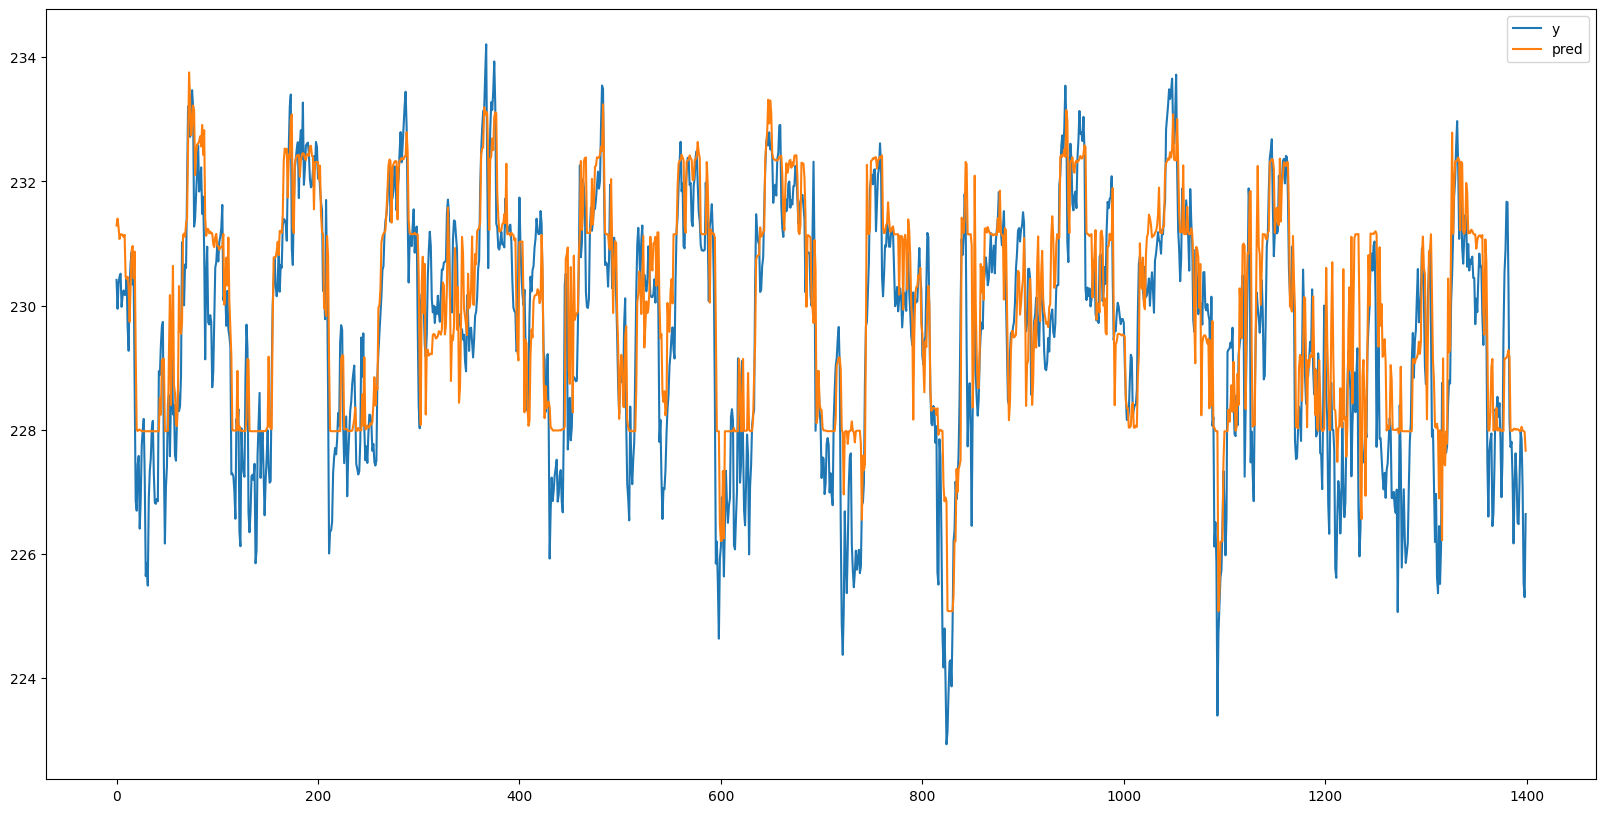

In [15]:
node = 50
pred_ind = 0

start = 0
len_measurements = 1400

plt.figure(figsize=(20,10))
plt.plot(ys[node,pred_ind,start:start+len_measurements], label="y")
plt.plot(preds[node,pred_ind,start:start+len_measurements], label="pred")
plt.legend()

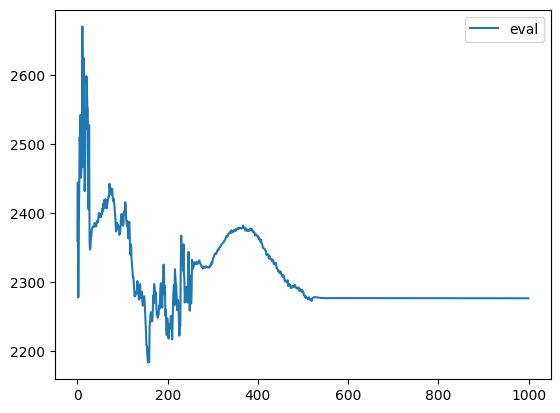

In [20]:
#plt.plot(losses_train, label="train")
#
plt.plot(losses_eval, label="eval")
plt.legend()

In [17]:
#create txt file at name_txt
with open(name_txt, "w") as f:
    #print losses
    f.write("train losses:\n")
    f.write(str(losses_train))
    f.write("\n")
    f.write("eval losses:\n")
    f.write(str(losses_eval))
    f.write("\n")
    f.write("test loss:\n")
    f.write(str(loss_test))
    f.write("\n")
    f.write(str(loss_test_timewise))
    f.write("\n")
    f.write(str(loss_test_elementwise))
    f.write("\n")

In [18]:
loader.get_snapshot(0).x.shape

torch.Size([113, 26, 12])